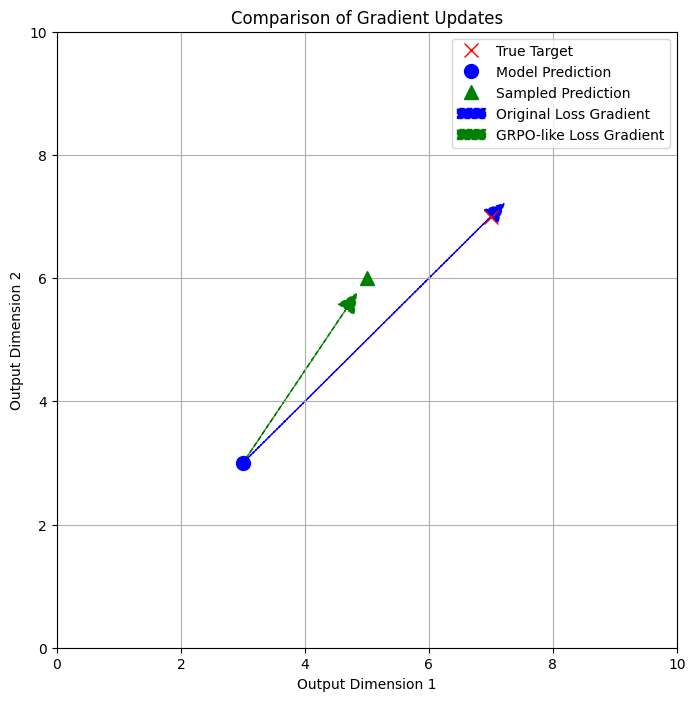

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("Output Dimension 1")
ax.set_ylabel("Output Dimension 2")
ax.set_title("Comparison of Gradient Updates")
ax.grid(True)

# Define positions for the points
vy_i = np.array([7, 7])  # True target
mu_theta = np.array([3, 3])  # Model prediction
vy_hat_i = np.array([5, 6])  # Sampled prediction

# Plot the points
ax.plot(vy_i[0], vy_i[1], "rx", markersize=10, label="True Target")
ax.plot(
    mu_theta[0],
    mu_theta[1],
    "bo",
    markersize=10,
    label="Model Prediction",
)
ax.plot(
    vy_hat_i[0],
    vy_hat_i[1],
    "g^",
    markersize=10,
    label="Sampled Prediction",
)

# Calculate gradients
gradient_original = vy_i - mu_theta  # Direction from model prediction to true target

# The GRPO-like gradient is in the direction from model prediction to sampled prediction,
# scaled by the squared distance between sampled prediction and true target
distance_squared = np.sum((vy_hat_i - vy_i) ** 2)
gradient_grpo = (vy_hat_i - mu_theta) * distance_squared

# For visualization purposes, we might want to normalize the arrows to make them comparable
# Alternatively, we can scale them such that they fit nicely in the plot.

# Let's scale down the GRPO gradient for visualization purposes if it's too large
max_arrow_length = 3  # Maximum length for visualization
if np.linalg.norm(gradient_grpo) > max_arrow_length:
    gradient_grpo = gradient_grpo / np.linalg.norm(gradient_grpo) * max_arrow_length

# Plot gradient vectors
ax.arrow(
    mu_theta[0],
    mu_theta[1],
    gradient_original[0],
    gradient_original[1],
    head_width=0.3,
    head_length=0.3,
    fc="blue",
    ec="blue",
    linestyle="--",
    label="Original Loss Gradient",
)
ax.arrow(
    mu_theta[0],
    mu_theta[1],
    gradient_grpo[0],
    gradient_grpo[1],
    head_width=0.3,
    head_length=0.3,
    fc="green",
    ec="green",
    linestyle="--",
    label="GRPO-like Loss Gradient",
)

ax.legend()
plt.show()

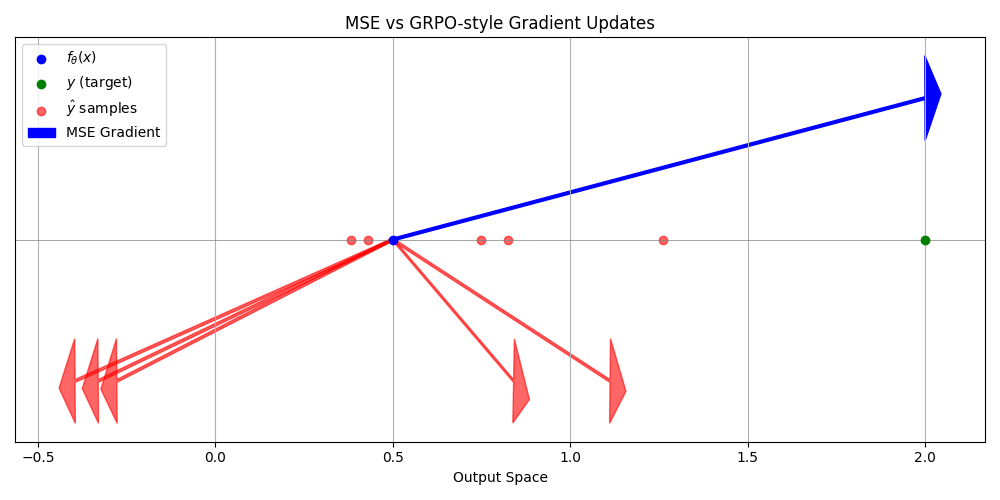

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
np.random.seed(42)
D = 1  # Dimensionality of x
theta = np.array([0.5])  # Model parameter
x = np.array([1.0])  # Input
y = 2.0  # True target
sigma = 0.5  # Std of prediction distribution
n_samples = 5  # Number of GRPO samples
distribution = "normal"  # Sampling distribution: "normal" or "uniform"

# Model prediction
f_theta_x = x @ theta

# MSE gradient
mse_grad = (f_theta_x - y) * x

# Sample predictions
if distribution == "normal":
    samples = np.random.normal(loc=f_theta_x, scale=sigma, size=n_samples)
elif distribution == "uniform":
    samples = np.random.uniform(
        low=f_theta_x - 2 * sigma, high=f_theta_x + 2 * sigma, size=n_samples
    )
else:
    raise ValueError("Unsupported distribution")

# GRPO gradients
grpo_grads = []
for y_hat in samples:
    reward = -0.5 * (y_hat - y) ** 2
    grad_log_prob = (y_hat - f_theta_x) / (sigma**2) * x
    grpo_grad = -reward * grad_log_prob
    grpo_grads.append(grpo_grad)

# Visualization
plt.figure(figsize=(10, 5))
plt.axhline(0, color="gray", linewidth=0.5)

# Plot points
plt.scatter([f_theta_x], [0], label=r"$f_\theta(x)$", color="blue", zorder=5)
plt.scatter([y], [0], label=r"$y$ (target)", color="green", zorder=5)
plt.scatter(
    samples, [0] * n_samples, label=r"$\hat{y}$ samples", color="red", alpha=0.6
)

# Plot MSE update arrow
plt.arrow(
    f_theta_x,
    0,
    -mse_grad[0],
    0.05,
    head_width=0.03,
    color="blue",
    label="MSE Gradient",
)

# Plot GRPO update arrows
for i, y_hat in enumerate(samples):
    grad = grpo_grads[i]
    plt.arrow(f_theta_x, 0, -grad[0], -0.05, head_width=0.03, color="red", alpha=0.6)

plt.title("MSE vs GRPO-style Gradient Updates")
plt.xlabel("Output Space")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib.widgets import Slider, Button, CheckButtons
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.patches as patches
from IPython.display import HTML

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
%matplotlib widget

In [4]:
class GradientVisualization:
    def __init__(self, figsize=(12, 8)):
        self.fig, self.ax = plt.subplots(figsize=figsize)

        # Initialize parameters
        self.num_samples = 8
        self.sigma = 0.3
        self.reward_scale = 2.0
        self.gradient_scale = 0.3
        self.sample_distribution = "gaussian"

        # Fixed positions
        self.true_target = np.array([3.0, 2.0])
        self.current_prediction = np.array([1.5, 3.0])

        # Animation parameters
        self.frame = 0
        self.samples_history = []
        self.gradient_history = []

        # Setup plot
        self.setup_plot()

    def setup_plot(self):
        self.ax.set_xlim(0, 5)
        self.ax.set_ylim(0, 5)
        self.ax.set_aspect("equal")
        self.ax.grid(True, alpha=0.3)
        self.ax.set_title(
            "Gradient Update Comparison: MSE vs GRPO", fontsize=14, fontweight="bold"
        )

        # Uncertainty ellipse
        self.uncertainty_ellipse = Ellipse(
            self.current_prediction,
            width=4 * self.sigma,
            height=3 * self.sigma,
            alpha=0.2,
            color="blue",
            linestyle="--",
        )
        self.ax.add_patch(self.uncertainty_ellipse)

        # Target and current prediction
        self.target_point = self.ax.scatter(
            self.true_target[0],
            self.true_target[1],
            c="green",
            s=200,
            marker="*",
            edgecolors="white",
            linewidth=2,
            label="True Target (y)",
            zorder=5,
        )

        self.current_point = self.ax.scatter(
            self.current_prediction[0],
            self.current_prediction[1],
            c="blue",
            s=120,
            marker="o",
            edgecolors="white",
            linewidth=2,
            label="Current μ(x)",
            zorder=5,
        )

        # Sample points
        self.sample_points = self.ax.scatter(
            [], [], c=[], s=[], alpha=0.7, cmap="Reds", zorder=4
        )

        # Gradient arrows
        self.mse_arrow = self.ax.annotate(
            "",
            xy=(0, 0),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", lw=4, color="green"),
        )
        self.grpo_arrow = self.ax.annotate(
            "",
            xy=(0, 0),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", lw=4, color="red"),
        )

        # Add text annotations
        self.ax.text(
            0.02,
            0.98,
            "Green: MSE Gradient",
            transform=self.ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8),
            verticalalignment="top",
            fontsize=10,
        )
        self.ax.text(
            0.02,
            0.88,
            "Red: GRPO Gradient",
            transform=self.ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8),
            verticalalignment="top",
            fontsize=10,
        )

        self.ax.legend(loc="upper right")

    def generate_samples(self):
        np.random.seed(self.frame)  # For reproducible animation

        if self.sample_distribution == "gaussian":
            samples = np.random.multivariate_normal(
                self.current_prediction, np.eye(2) * self.sigma**2, self.num_samples
            )
        elif self.sample_distribution == "uniform":
            samples = np.random.uniform(
                self.current_prediction - self.sigma * 2,
                self.current_prediction + self.sigma * 2,
                (self.num_samples, 2),
            )
        else:  # mixture
            n_mix = self.num_samples // 2
            samples1 = np.random.multivariate_normal(
                self.current_prediction + np.array([0.2, 0.2]),
                np.eye(2) * self.sigma**2,
                n_mix,
            )
            samples2 = np.random.multivariate_normal(
                self.current_prediction - np.array([0.2, 0.2]),
                np.eye(2) * self.sigma**2,
                self.num_samples - n_mix,
            )
            samples = np.vstack([samples1, samples2])

        return samples

    def calculate_rewards(self, samples):
        distances = np.linalg.norm(samples - self.true_target, axis=1)
        rewards = -(distances**2)
        return rewards

    def calculate_gradients(self, samples, rewards):
        # MSE gradient
        mse_grad = (self.true_target - self.current_prediction) * self.gradient_scale

        # GRPO gradient
        weights = np.exp(rewards * self.reward_scale)
        weights = weights / (np.sum(weights) + 1e-8)

        sample_directions = samples - self.current_prediction
        grpo_grad = (
            np.sum(weights[:, np.newaxis] * sample_directions, axis=0)
            * self.gradient_scale
        )

        return mse_grad, grpo_grad

    def update_plot(self, frame_num=None):
        if frame_num is not None:
            self.frame = frame_num

        samples = self.generate_samples()
        rewards = self.calculate_rewards(samples)
        mse_grad, grpo_grad = self.calculate_gradients(samples, rewards)

        # Update sample points
        colors = (rewards - np.min(rewards)) / (
            np.max(rewards) - np.min(rewards) + 1e-8
        )
        sizes = 50 + 100 * colors

        self.sample_points.set_offsets(samples)
        self.sample_points.set_array(colors)
        self.sample_points.set_sizes(sizes)

        # Update arrows
        self.mse_arrow.set_position(
            (self.current_prediction[0], self.current_prediction[1])
        )
        self.mse_arrow.xy = self.current_prediction + mse_grad

        self.grpo_arrow.set_position(
            (self.current_prediction[0], self.current_prediction[1])
        )
        self.grpo_arrow.xy = self.current_prediction + grpo_grad

        # Update uncertainty ellipse
        self.uncertainty_ellipse.center = self.current_prediction
        self.uncertainty_ellipse.width = 4 * self.sigma
        self.uncertainty_ellipse.height = 3 * self.sigma

        # Update title with metrics
        mse_magnitude = np.linalg.norm(mse_grad)
        grpo_magnitude = np.linalg.norm(grpo_grad)

        if mse_magnitude > 0 and grpo_magnitude > 0:
            angle_diff = np.arccos(
                np.clip(
                    np.dot(mse_grad, grpo_grad) / (mse_magnitude * grpo_magnitude),
                    -1,
                    1,
                )
            )
            angle_diff_deg = np.degrees(angle_diff)
        else:
            angle_diff_deg = 0

        self.ax.set_title(
            f"MSE: {mse_magnitude:.2f} | GRPO: {grpo_magnitude:.2f} | Angle Diff: {angle_diff_deg:.1f}°",
            fontsize=12,
            fontweight="bold",
        )

        # Store history for analysis
        self.samples_history.append(samples.copy())
        self.gradient_history.append(
            {
                "mse_grad": mse_grad.copy(),
                "grpo_grad": grpo_grad.copy(),
                "mse_magnitude": mse_magnitude,
                "grpo_magnitude": grpo_magnitude,
                "angle_diff": angle_diff_deg,
            }
        )

        return [
            self.sample_points,
            self.mse_arrow,
            self.grpo_arrow,
            self.uncertainty_ellipse,
        ]


class InteractiveGradientViz:
    def __init__(self):
        self.viz = GradientVisualization()
        self.setup_widgets()
        self.animation = None
        self.is_playing = False

    def setup_widgets(self):
        # Parameter sliders
        self.num_samples_slider = widgets.IntSlider(
            value=8,
            min=1,
            max=20,
            step=1,
            description="# Samples:",
            style={"description_width": "initial"},
        )

        self.sigma_slider = widgets.FloatSlider(
            value=0.3,
            min=0.1,
            max=1.0,
            step=0.05,
            description="Sigma:",
            style={"description_width": "initial"},
        )

        self.reward_scale_slider = widgets.FloatSlider(
            value=2.0,
            min=0.5,
            max=5.0,
            step=0.1,
            description="Reward Scale:",
            style={"description_width": "initial"},
        )

        self.gradient_scale_slider = widgets.FloatSlider(
            value=0.3,
            min=0.1,
            max=1.0,
            step=0.05,
            description="Gradient Scale:",
            style={"description_width": "initial"},
        )

        # Distribution selector
        self.distribution_dropdown = widgets.Dropdown(
            options=["gaussian", "uniform", "mixture"],
            value="gaussian",
            description="Distribution:",
        )

        # Animation controls
        self.play_button = widgets.Button(
            description="Play/Pause", button_style="success"
        )
        self.reset_button = widgets.Button(description="Reset", button_style="info")
        self.single_step_button = widgets.Button(
            description="Single Step", button_style="warning"
        )

        # Bind events
        self.num_samples_slider.observe(self.update_parameters, names="value")
        self.sigma_slider.observe(self.update_parameters, names="value")
        self.reward_scale_slider.observe(self.update_parameters, names="value")
        self.gradient_scale_slider.observe(self.update_parameters, names="value")
        self.distribution_dropdown.observe(self.update_distribution, names="value")

        self.play_button.on_click(self.toggle_animation)
        self.reset_button.on_click(self.reset_animation)
        self.single_step_button.on_click(self.single_step)

    def update_parameters(self, change):
        self.viz.num_samples = self.num_samples_slider.value
        self.viz.sigma = self.sigma_slider.value
        self.viz.reward_scale = self.reward_scale_slider.value
        self.viz.gradient_scale = self.gradient_scale_slider.value
        self.viz.update_plot()

    def update_distribution(self, change):
        self.viz.sample_distribution = self.distribution_dropdown.value
        self.viz.update_plot()

    def toggle_animation(self, b):
        if self.animation is None:
            self.animation = animation.FuncAnimation(
                self.viz.fig,
                self.viz.update_plot,
                frames=range(1000),
                interval=200,
                blit=False,
                repeat=True,
            )
        else:
            if self.is_playing:
                self.animation.pause()
                self.play_button.description = "Play"
            else:
                self.animation.resume()
                self.play_button.description = "Pause"

        self.is_playing = not self.is_playing

    def reset_animation(self, b):
        self.viz.frame = 0
        self.viz.samples_history = []
        self.viz.gradient_history = []
        if self.animation is not None:
            self.animation.pause()
            self.is_playing = False
            self.play_button.description = "Play"
        self.viz.update_plot(0)

    def single_step(self, b):
        self.viz.frame += 1
        self.viz.update_plot()

    def display(self):
        # Layout widgets
        param_controls = widgets.VBox(
            [
                widgets.HTML("<h3>Parameters</h3>"),
                self.num_samples_slider,
                self.sigma_slider,
                self.reward_scale_slider,
                self.gradient_scale_slider,
                self.distribution_dropdown,
            ]
        )

        animation_controls = widgets.VBox(
            [
                widgets.HTML("<h3>Animation</h3>"),
                self.play_button,
                self.reset_button,
                self.single_step_button,
            ]
        )

        controls = widgets.HBox([param_controls, animation_controls])

        display(controls)
        display(self.viz.fig)

        # Initial plot
        self.viz.update_plot()

In [5]:
def analyze_gradient_patterns(viz, num_steps=50):
    """Analyze gradient patterns over multiple steps"""
    viz.samples_history = []
    viz.gradient_history = []

    for step in range(num_steps):
        viz.frame = step
        viz.update_plot()

    # Extract data
    mse_magnitudes = [h["mse_magnitude"] for h in viz.gradient_history]
    grpo_magnitudes = [h["grpo_magnitude"] for h in viz.gradient_history]
    angle_diffs = [h["angle_diff"] for h in viz.gradient_history]

    # Plot analysis
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Magnitude comparison
    axes[0, 0].plot(mse_magnitudes, label="MSE", color="green", linewidth=2)
    axes[0, 0].plot(grpo_magnitudes, label="GRPO", color="red", linewidth=2)
    axes[0, 0].set_title("Gradient Magnitudes Over Time")
    axes[0, 0].set_xlabel("Step")
    axes[0, 0].set_ylabel("Magnitude")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Angle differences
    axes[0, 1].plot(angle_diffs, color="purple", linewidth=2)
    axes[0, 1].set_title("Angle Difference Between Gradients")
    axes[0, 1].set_xlabel("Step")
    axes[0, 1].set_ylabel("Angle (degrees)")
    axes[0, 1].grid(True, alpha=0.3)

    # Magnitude ratio
    ratios = [g / m if m > 0 else 0 for g, m in zip(grpo_magnitudes, mse_magnitudes)]
    axes[1, 0].plot(ratios, color="orange", linewidth=2)
    axes[1, 0].set_title("GRPO/MSE Magnitude Ratio")
    axes[1, 0].set_xlabel("Step")
    axes[1, 0].set_ylabel("Ratio")
    axes[1, 0].grid(True, alpha=0.3)

    # Statistics
    axes[1, 1].hist(angle_diffs, bins=20, alpha=0.7, color="purple")
    axes[1, 1].set_title("Distribution of Angle Differences")
    axes[1, 1].set_xlabel("Angle (degrees)")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Analysis Results ({num_steps} steps):")
    print(f"Average MSE magnitude: {np.mean(mse_magnitudes):.3f}")
    print(f"Average GRPO magnitude: {np.mean(grpo_magnitudes):.3f}")
    print(f"Average angle difference: {np.mean(angle_diffs):.1f}°")
    print(f"Std angle difference: {np.std(angle_diffs):.1f}°")
    print(f"Max angle difference: {np.max(angle_diffs):.1f}°")


def compare_distributions(num_samples=10, sigma=0.3, reward_scale=2.0):
    """Compare different sampling distributions"""
    distributions = ["gaussian", "uniform", "mixture"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, dist in enumerate(distributions):
        viz = GradientVisualization()
        viz.num_samples = num_samples
        viz.sigma = sigma
        viz.reward_scale = reward_scale
        viz.sample_distribution = dist

        # Generate multiple samples to show distribution
        all_samples = []
        for _ in range(20):
            samples = viz.generate_samples()
            all_samples.append(samples)
        all_samples = np.vstack(all_samples)

        # Plot
        axes[i].scatter(all_samples[:, 0], all_samples[:, 1], alpha=0.3, s=20)
        axes[i].scatter(
            *viz.current_prediction, c="blue", s=100, marker="o", label="Current μ(x)"
        )
        axes[i].scatter(
            *viz.true_target, c="green", s=100, marker="*", label="True Target"
        )
        axes[i].set_title(f"{dist.capitalize()} Distribution")
        axes[i].set_xlim(0, 5)
        axes[i].set_ylim(0, 5)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

    plt.tight_layout()
    plt.show()


# Cell 5: Experiment Runner
def run_parameter_experiment():
    """Run systematic experiments with different parameter combinations"""
    print("Running parameter sensitivity analysis...")

    # Parameter ranges
    num_samples_range = [5, 10, 15, 20]
    sigma_range = [0.2, 0.4, 0.6, 0.8]
    reward_scale_range = [1.0, 2.0, 3.0, 4.0]

    results = []

    for n_samples in num_samples_range:
        for sigma in sigma_range:
            for reward_scale in reward_scale_range:
                viz = GradientVisualization()
                viz.num_samples = n_samples
                viz.sigma = sigma
                viz.reward_scale = reward_scale

                # Run multiple steps to get average behavior
                angle_diffs = []
                magnitude_ratios = []

                for step in range(10):
                    viz.frame = step
                    samples = viz.generate_samples()
                    rewards = viz.calculate_rewards(samples)
                    mse_grad, grpo_grad = viz.calculate_gradients(samples, rewards)

                    mse_mag = np.linalg.norm(mse_grad)
                    grpo_mag = np.linalg.norm(grpo_grad)

                    if mse_mag > 0 and grpo_mag > 0:
                        angle_diff = np.degrees(
                            np.arccos(
                                np.clip(
                                    np.dot(mse_grad, grpo_grad) / (mse_mag * grpo_mag),
                                    -1,
                                    1,
                                )
                            )
                        )
                        angle_diffs.append(angle_diff)
                        magnitude_ratios.append(grpo_mag / mse_mag)

                results.append(
                    {
                        "n_samples": n_samples,
                        "sigma": sigma,
                        "reward_scale": reward_scale,
                        "avg_angle_diff": np.mean(angle_diffs),
                        "std_angle_diff": np.std(angle_diffs),
                        "avg_magnitude_ratio": np.mean(magnitude_ratios),
                    }
                )

    # Convert to numpy array for analysis
    import pandas as pd

    df = pd.DataFrame(results)

    # Display summary
    print("\nParameter Sensitivity Summary:")
    print("=" * 50)

    print("Effect of Number of Samples:")
    for n in num_samples_range:
        subset = df[df["n_samples"] == n]
        print(f"  {n} samples: avg angle diff = {subset['avg_angle_diff'].mean():.1f}°")

    print("\nEffect of Sigma:")
    for s in sigma_range:
        subset = df[df["sigma"] == s]
        print(f"  σ = {s}: avg angle diff = {subset['avg_angle_diff'].mean():.1f}°")

    print("\nEffect of Reward Scale:")
    for r in reward_scale_range:
        subset = df[df["reward_scale"] == r]
        print(
            f"  reward scale = {r}: avg angle diff = {subset['avg_angle_diff'].mean():.1f}°"
        )

    return df

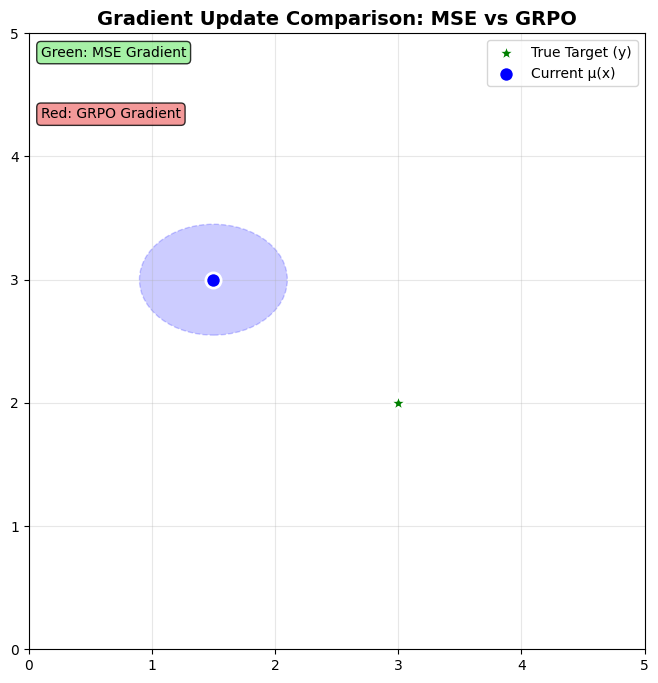

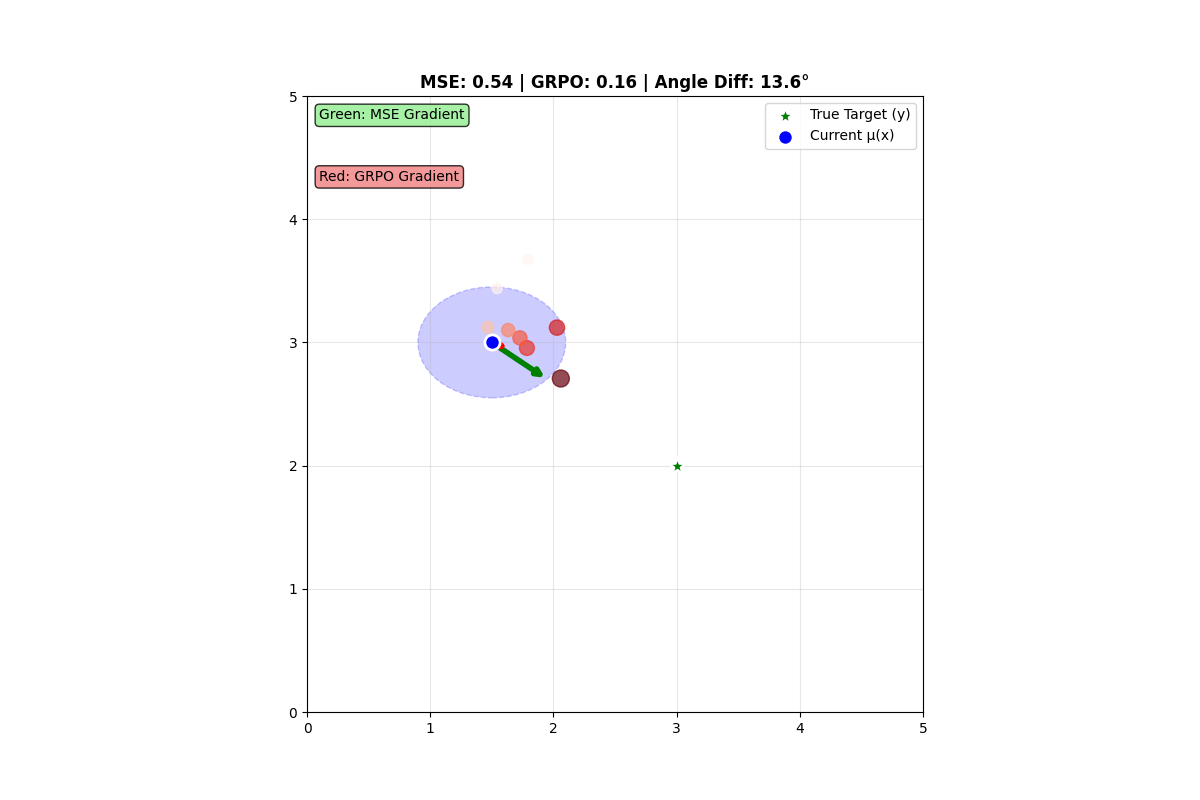

In [6]:
viz = InteractiveGradientViz()
viz.display()

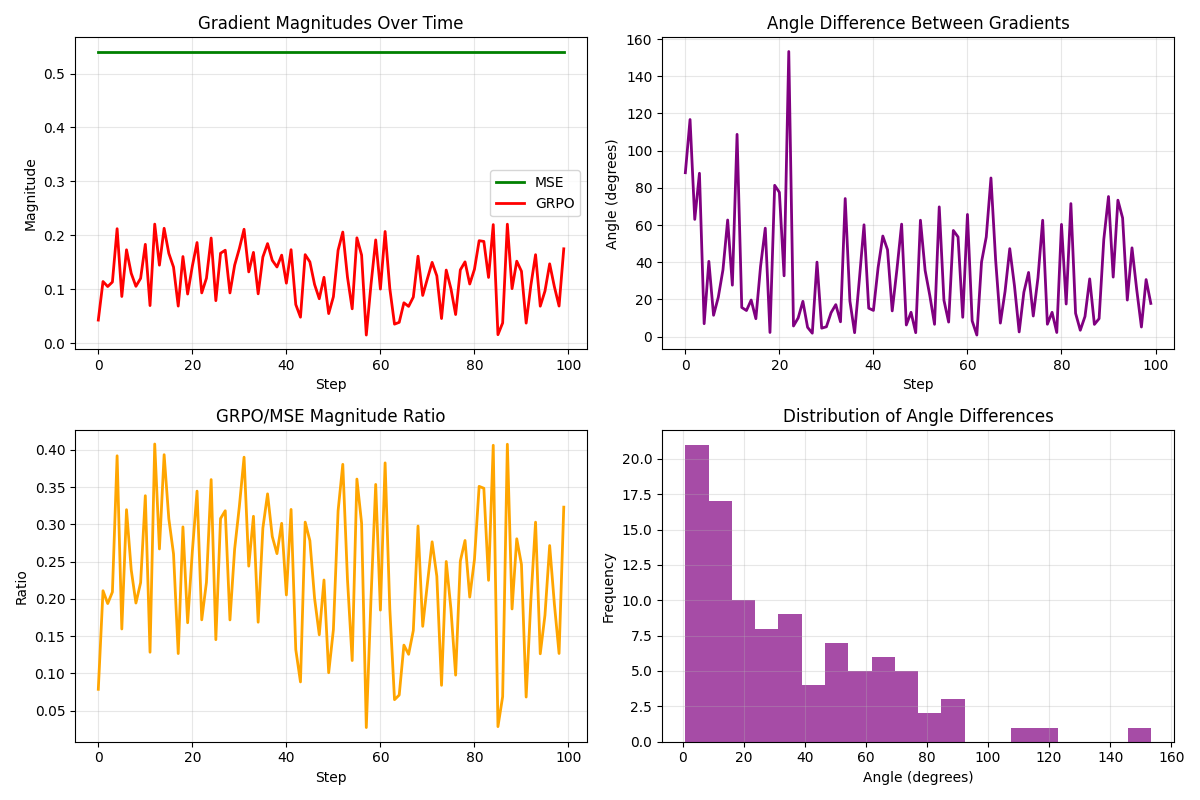

Analysis Results (100 steps):
Average MSE magnitude: 0.541
Average GRPO magnitude: 0.126
Average angle difference: 33.9°
Std angle difference: 29.4°
Max angle difference: 153.3°


In [7]:
analyze_gradient_patterns(viz.viz, num_steps=100)

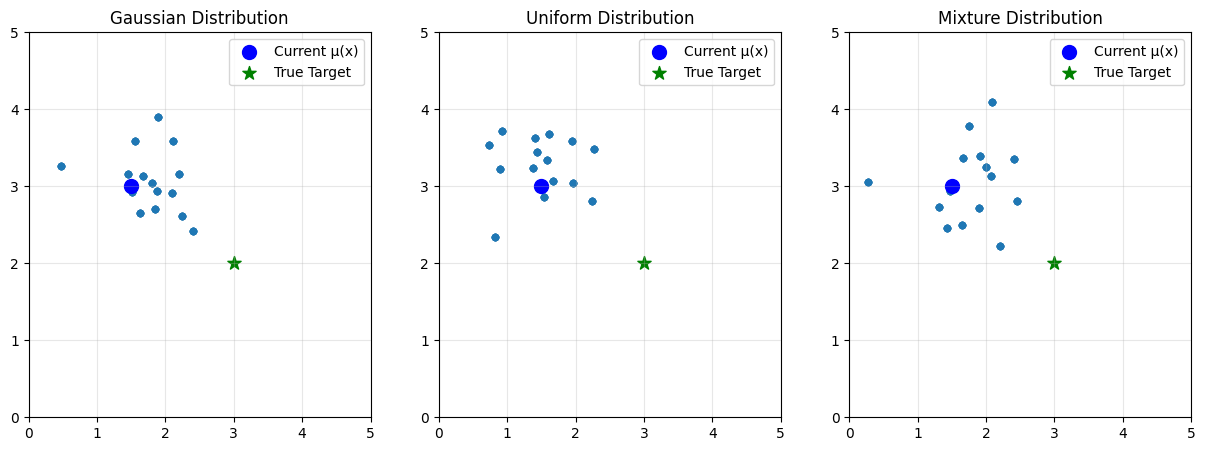

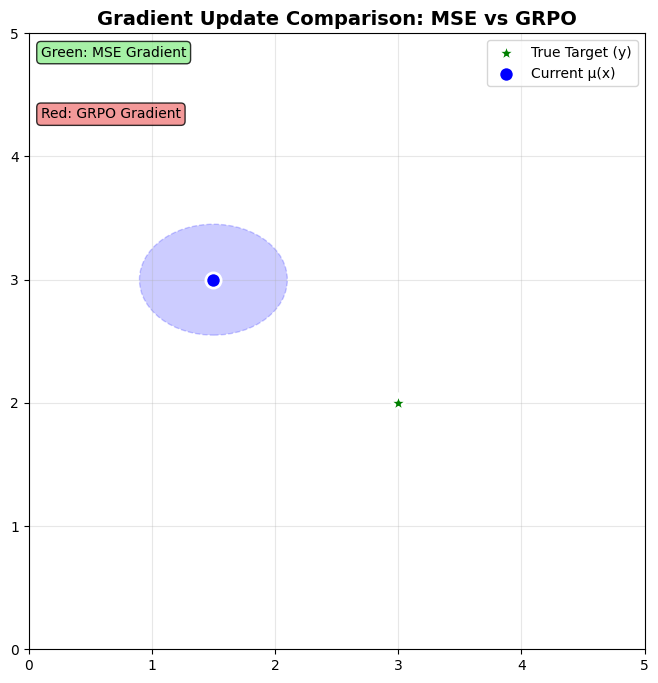

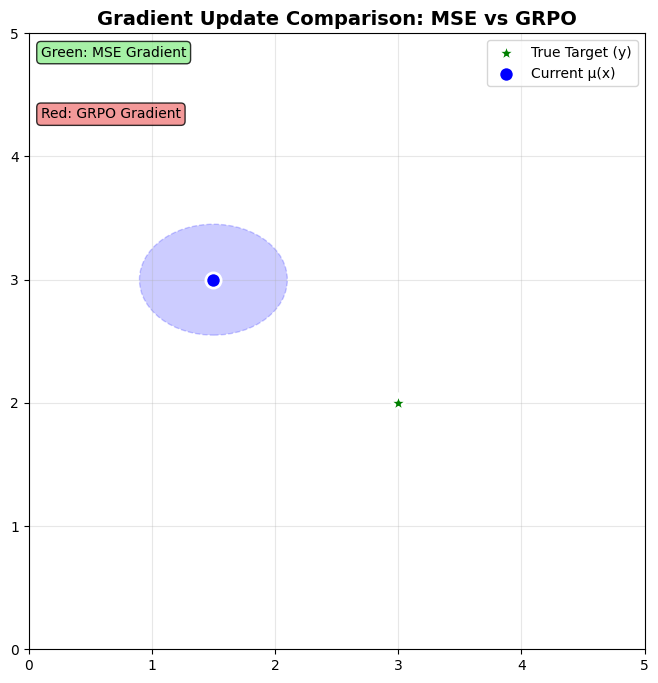

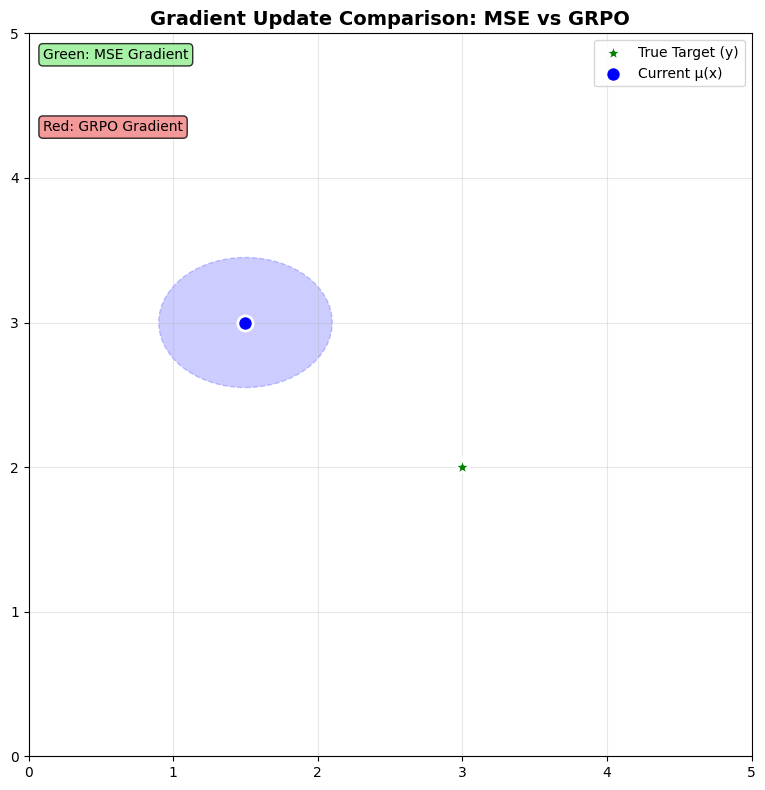

In [8]:
compare_distributions(num_samples=15, sigma=0.4)

Running parameter sensitivity analysis...


/tmp/ipykernel_1407970/1823209068.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(figsize=figsize)



Parameter Sensitivity Summary:
Effect of Number of Samples:
  5 samples: avg angle diff = 33.1°
  10 samples: avg angle diff = 17.4°
  15 samples: avg angle diff = 12.8°
  20 samples: avg angle diff = 12.4°

Effect of Sigma:
  σ = 0.2: avg angle diff = 22.7°
  σ = 0.4: avg angle diff = 18.5°
  σ = 0.6: avg angle diff = 17.5°
  σ = 0.8: avg angle diff = 17.0°

Effect of Reward Scale:
  reward scale = 1.0: avg angle diff = 21.4°
  reward scale = 2.0: avg angle diff = 18.3°
  reward scale = 3.0: avg angle diff = 17.9°
  reward scale = 4.0: avg angle diff = 18.2°


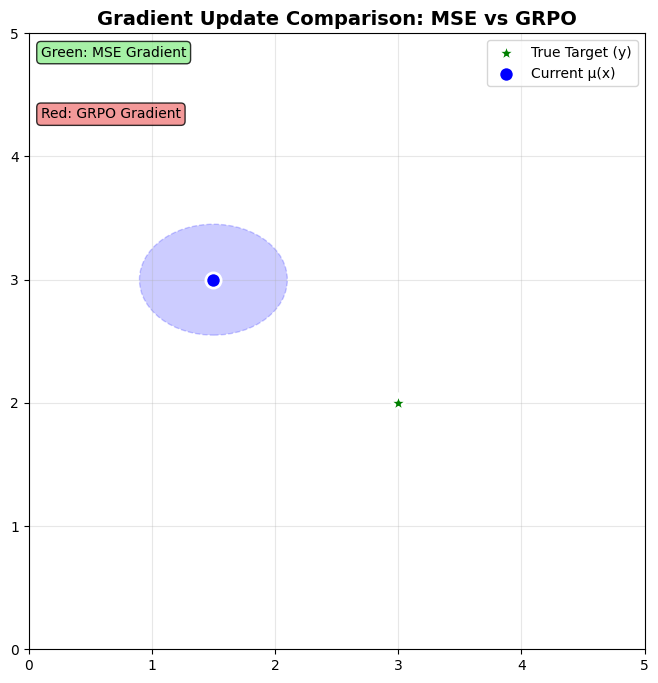

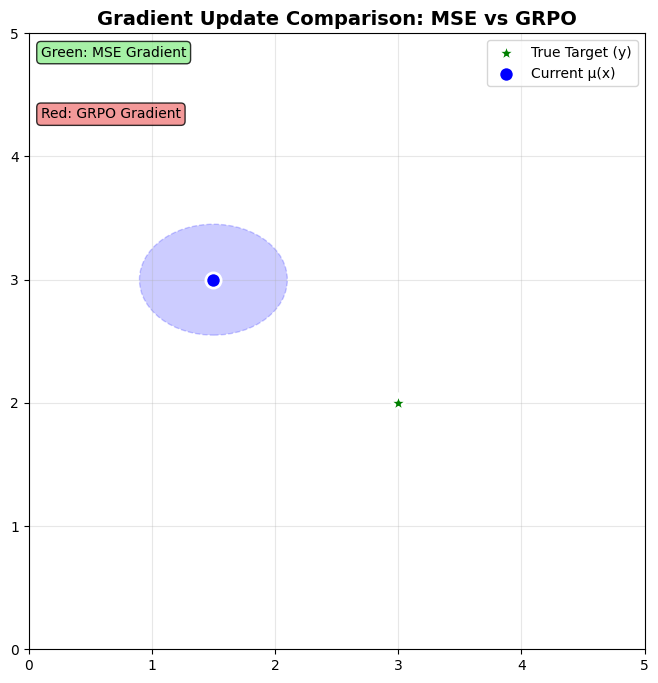

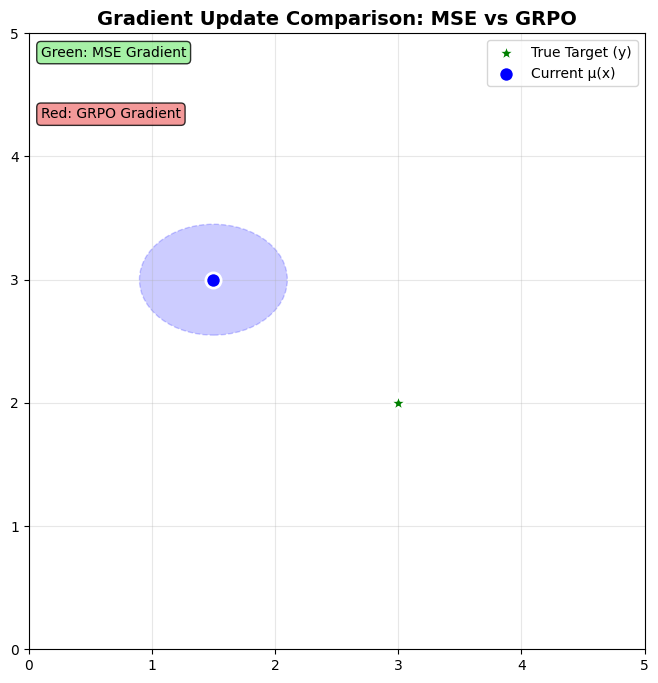

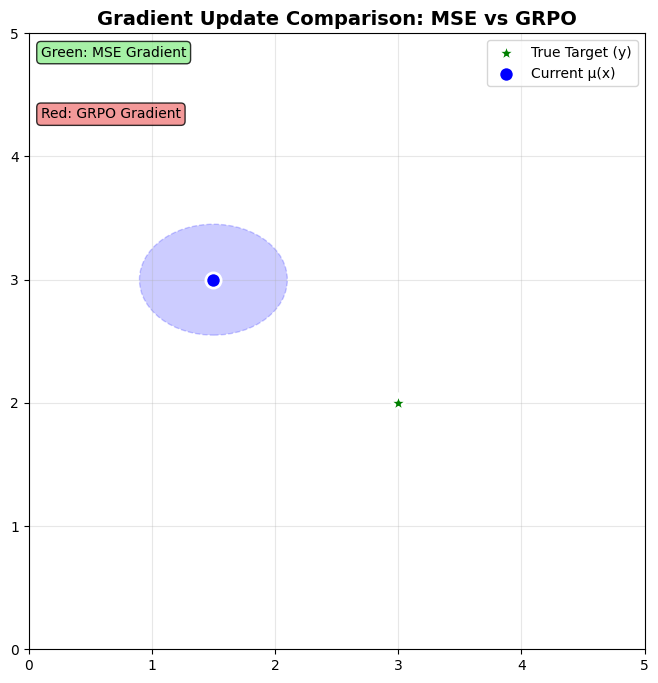

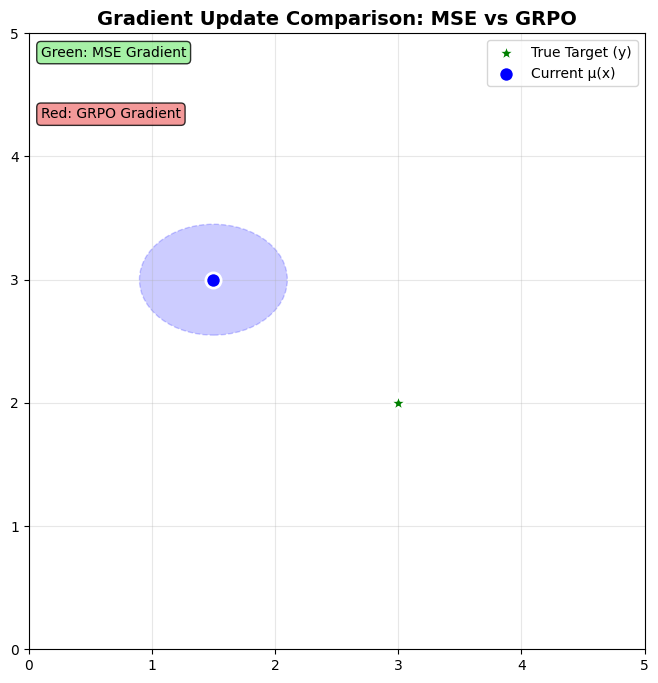

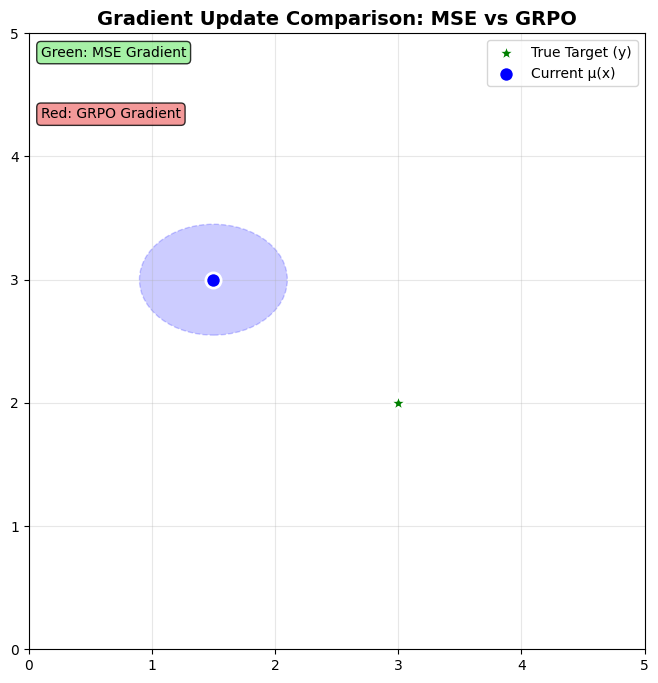

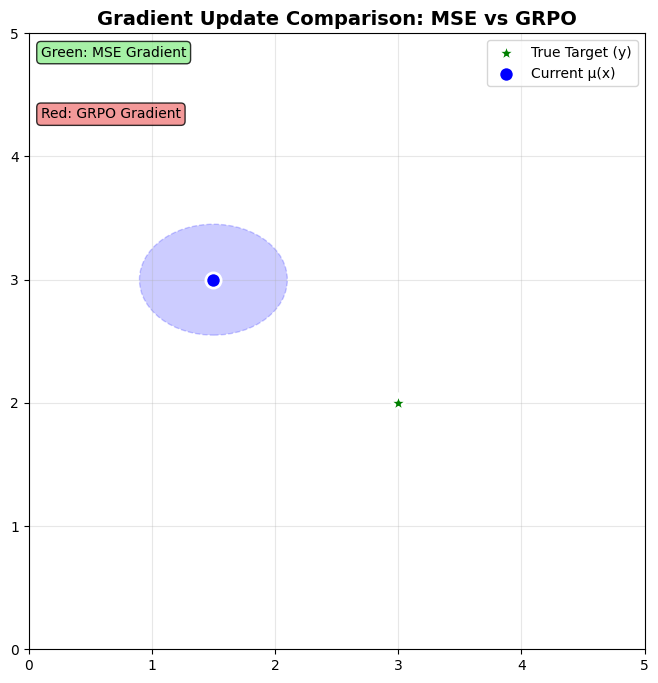

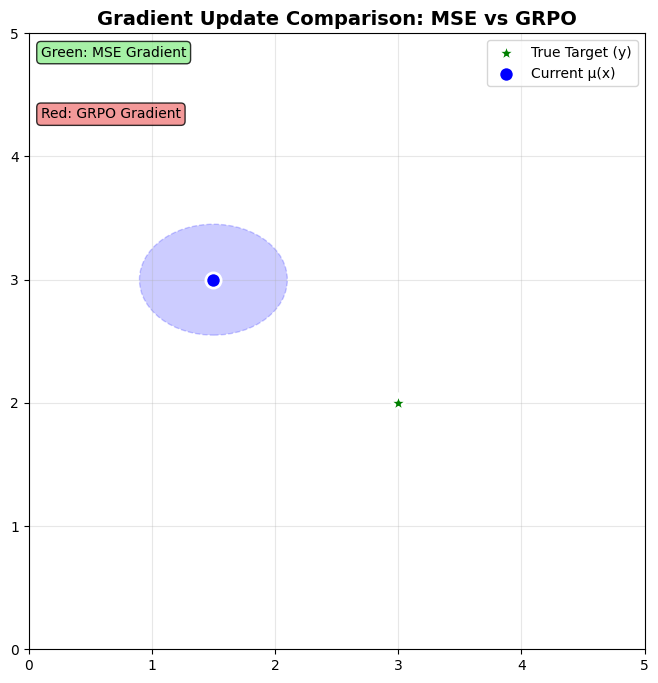

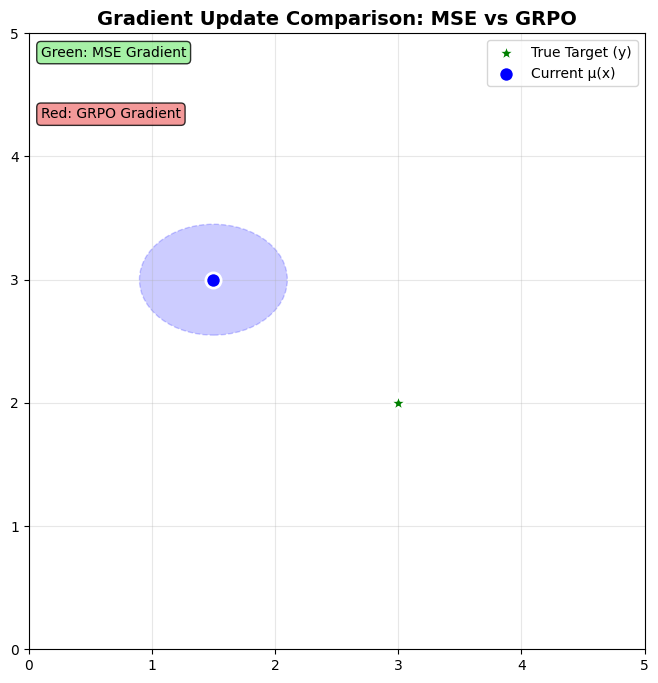

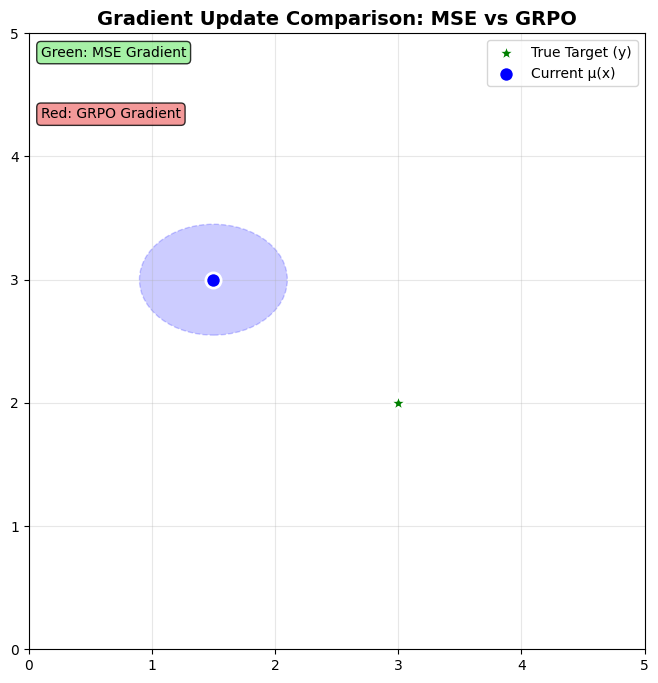

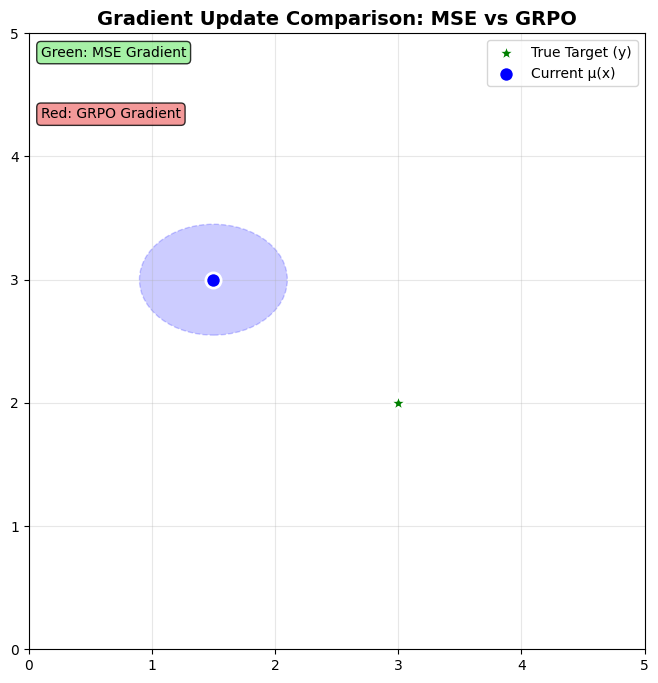

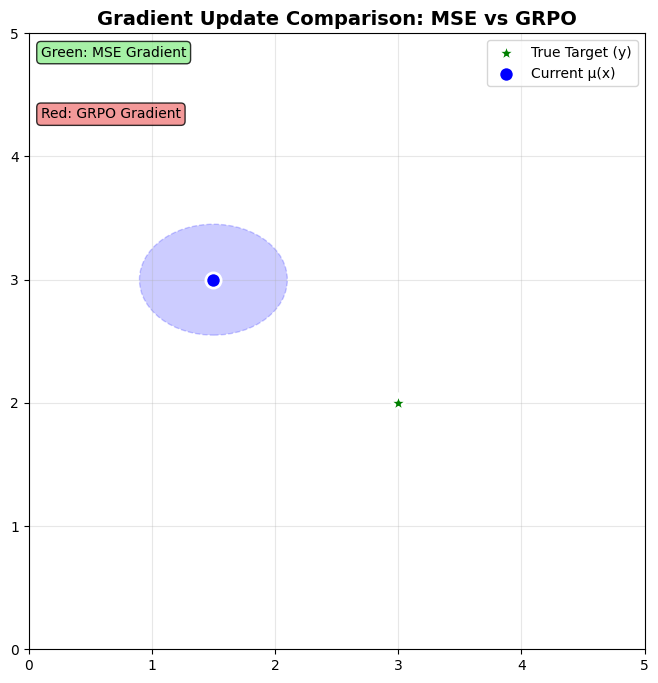

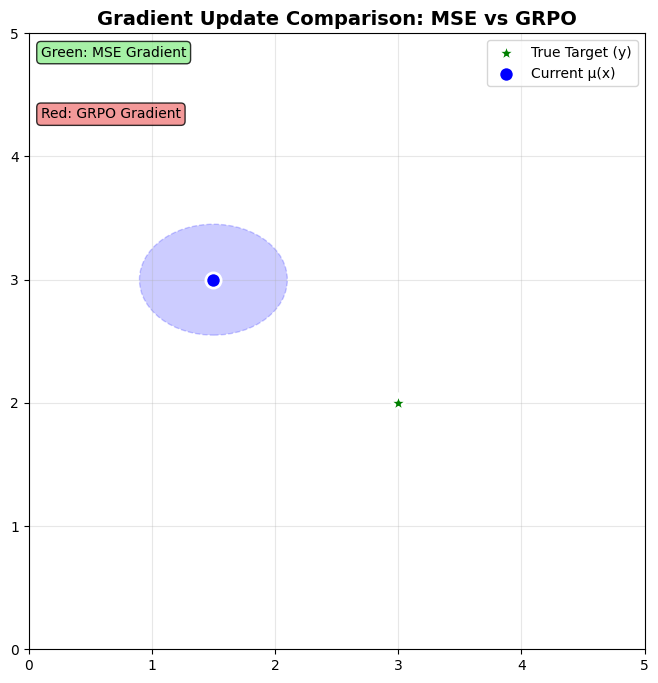

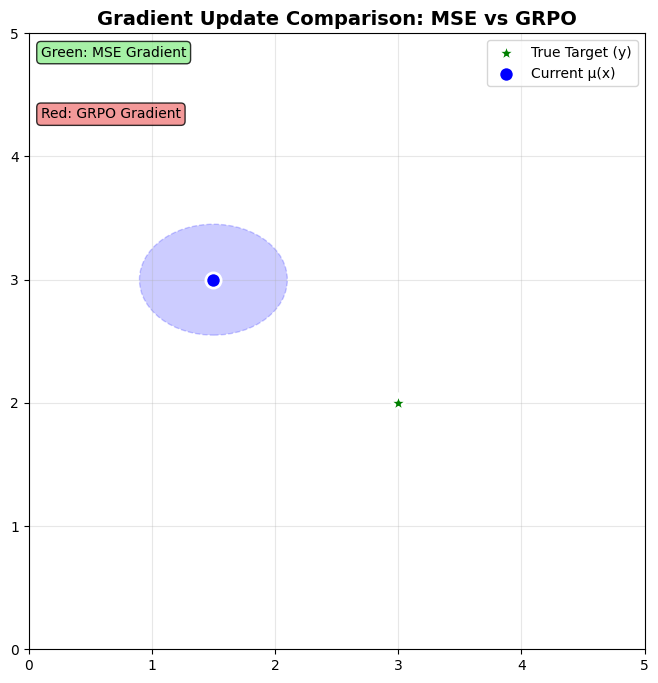

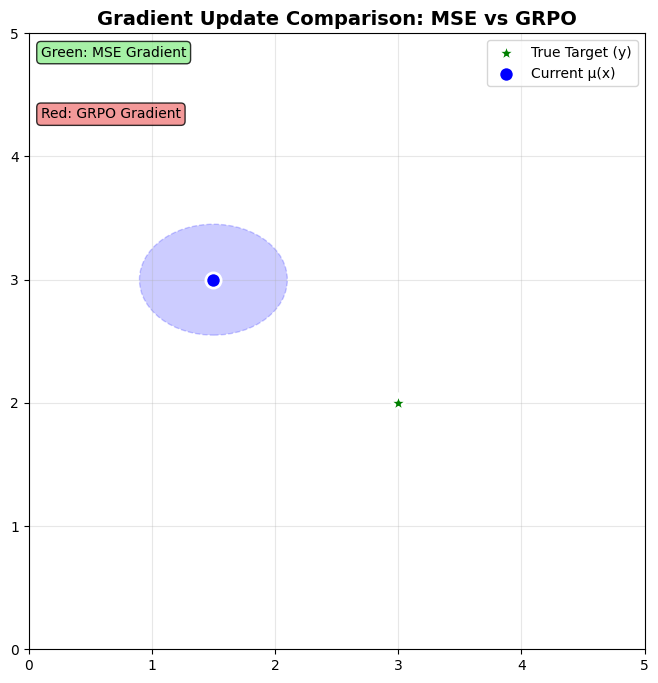

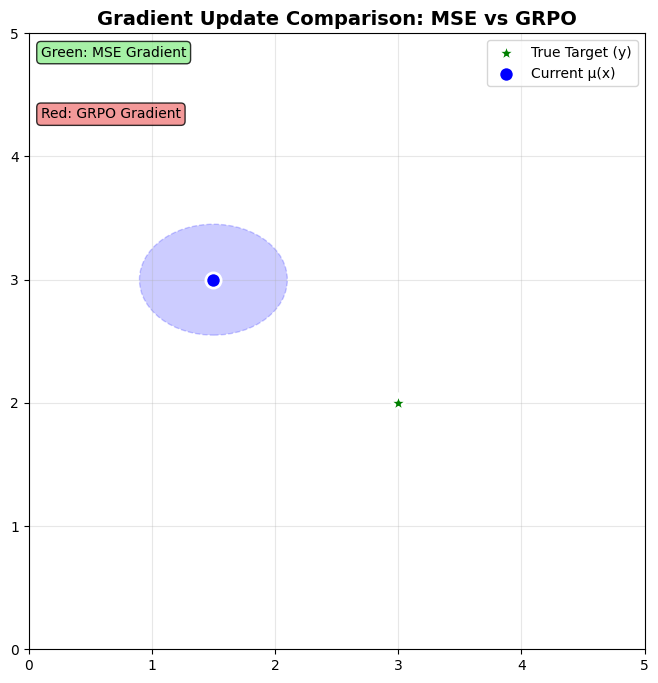

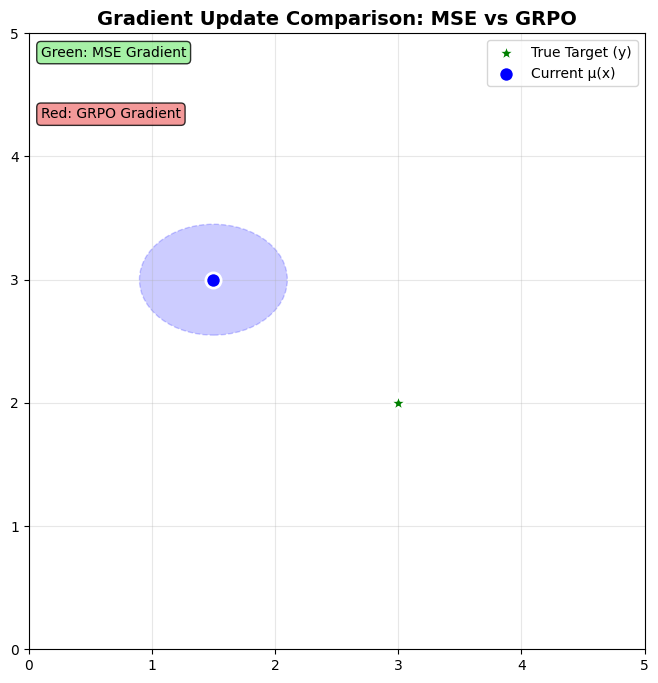

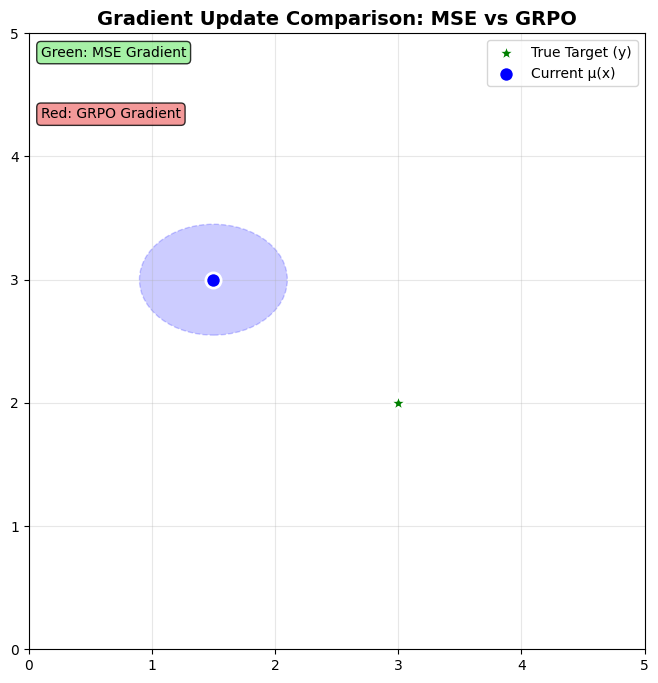

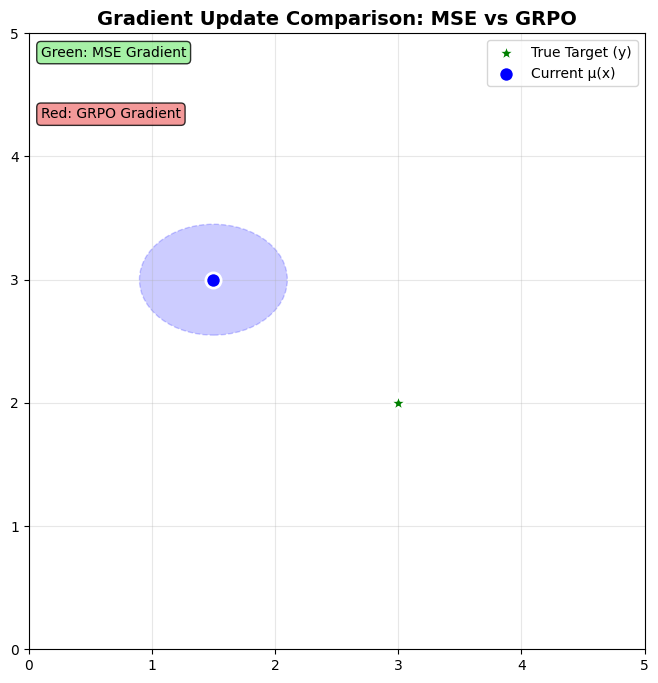

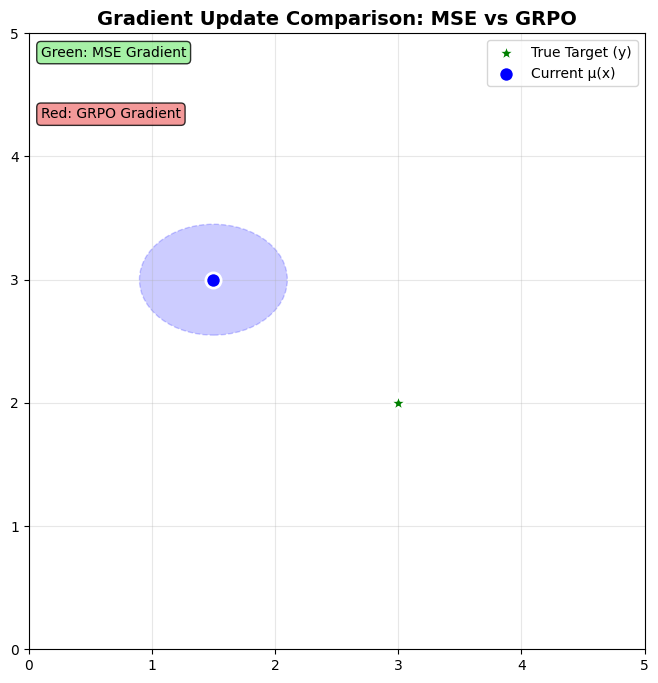

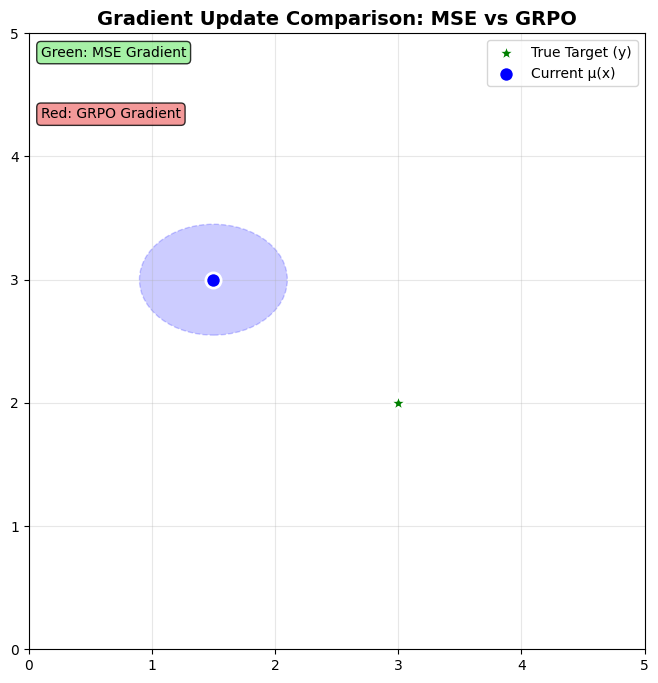

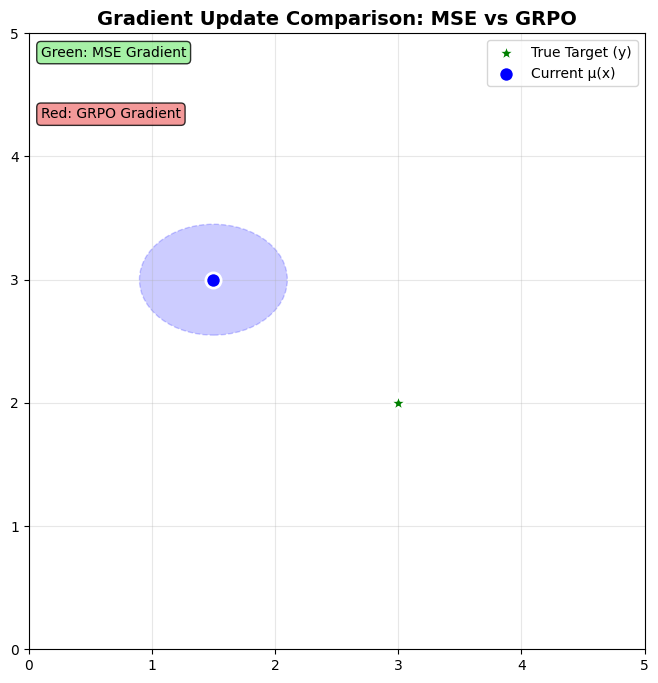

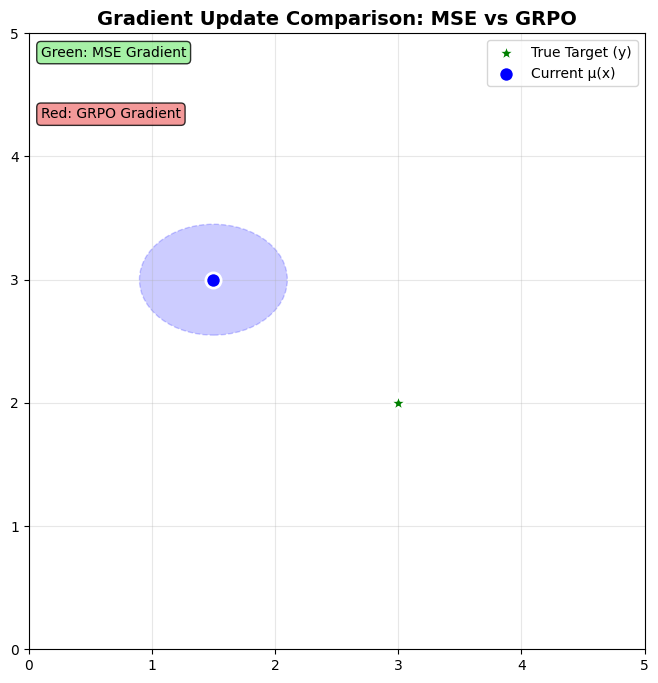

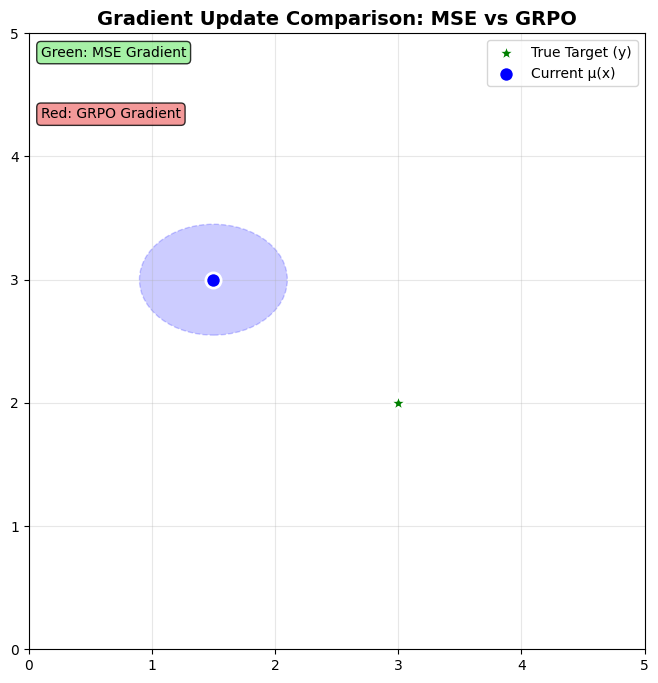

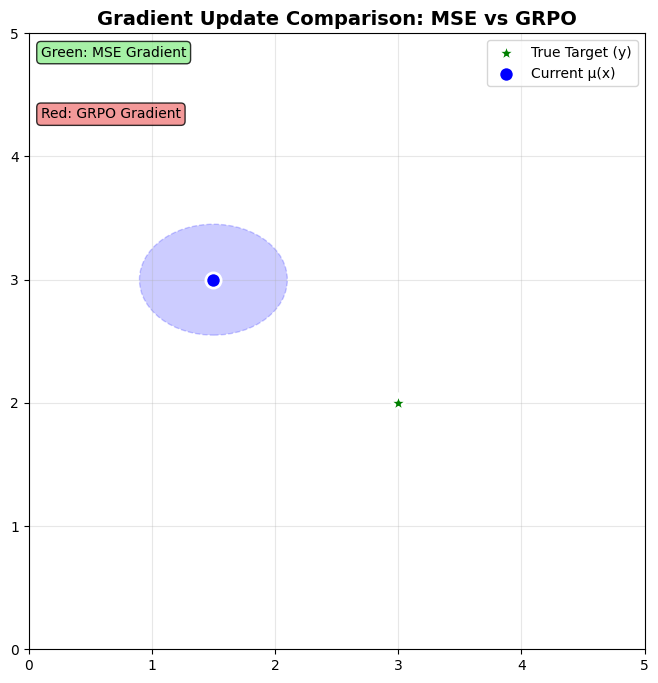

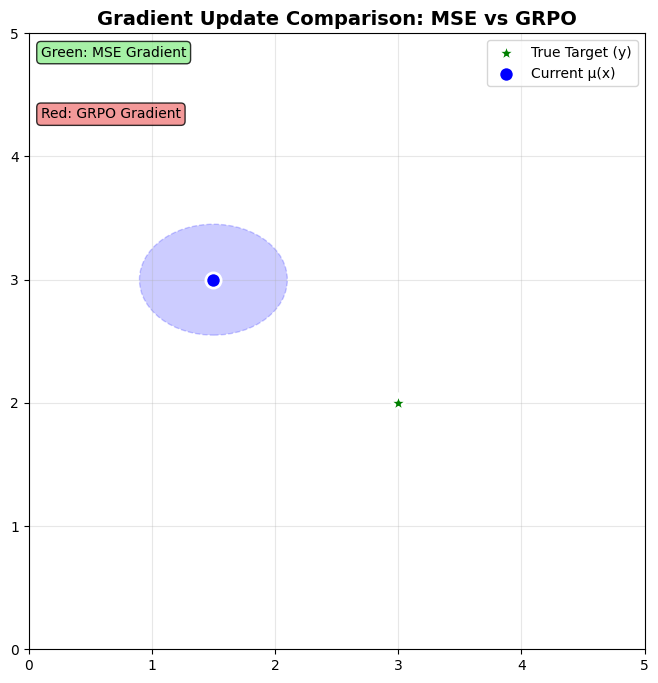

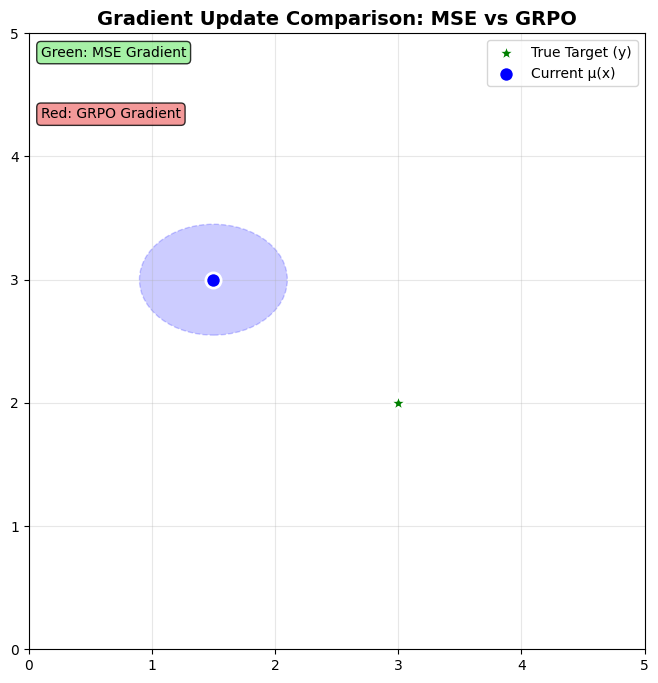

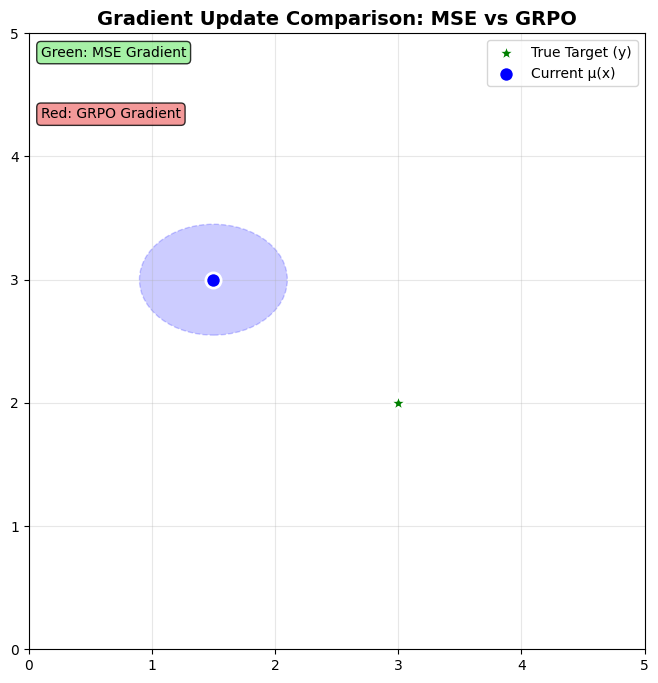

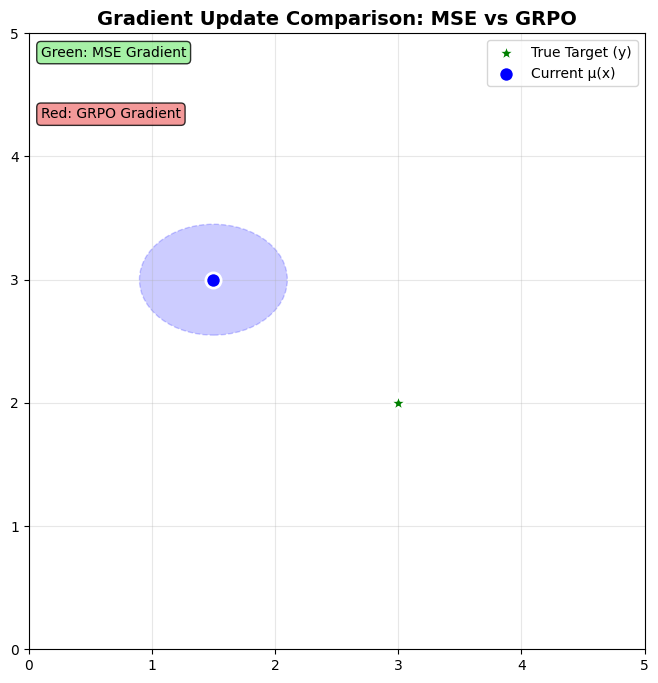

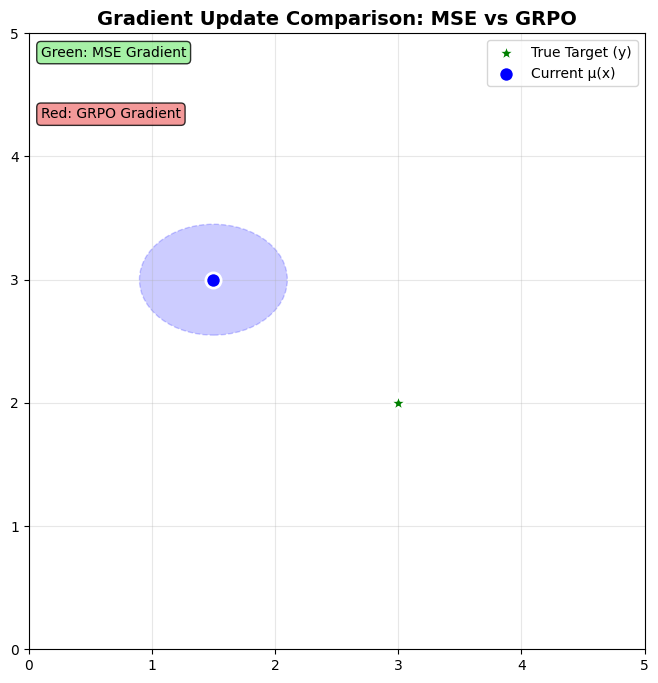

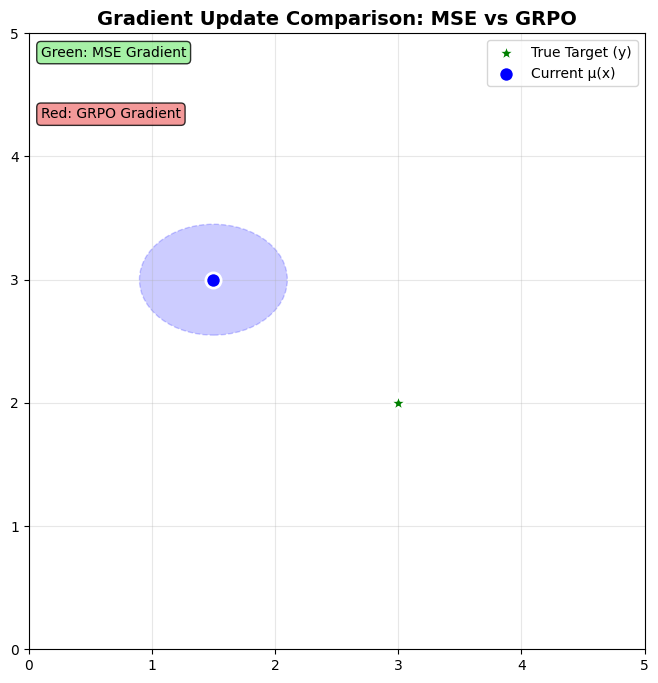

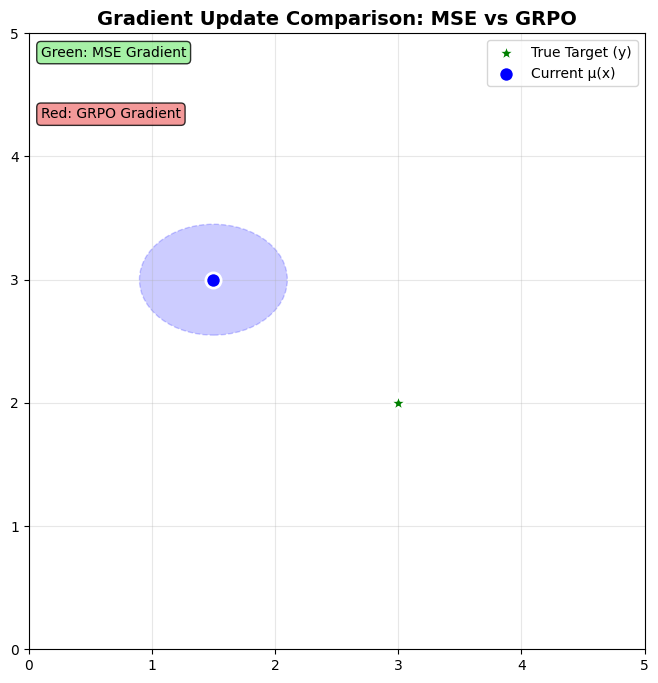

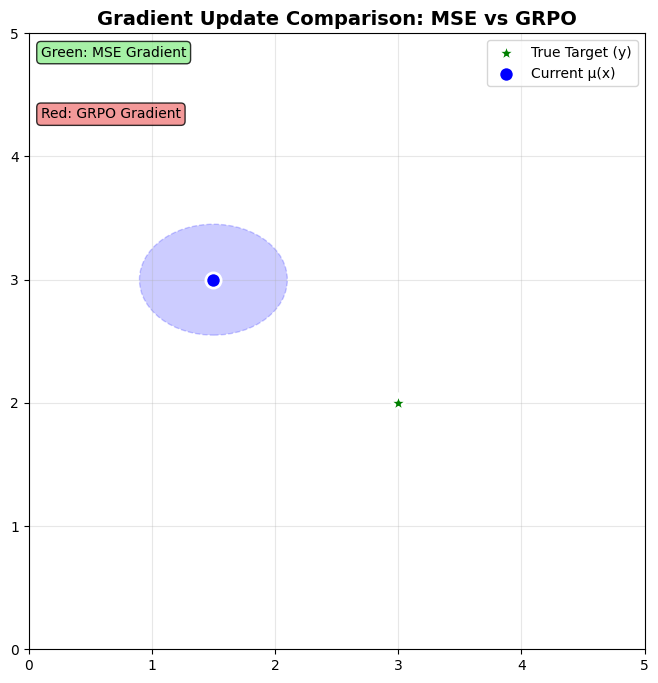

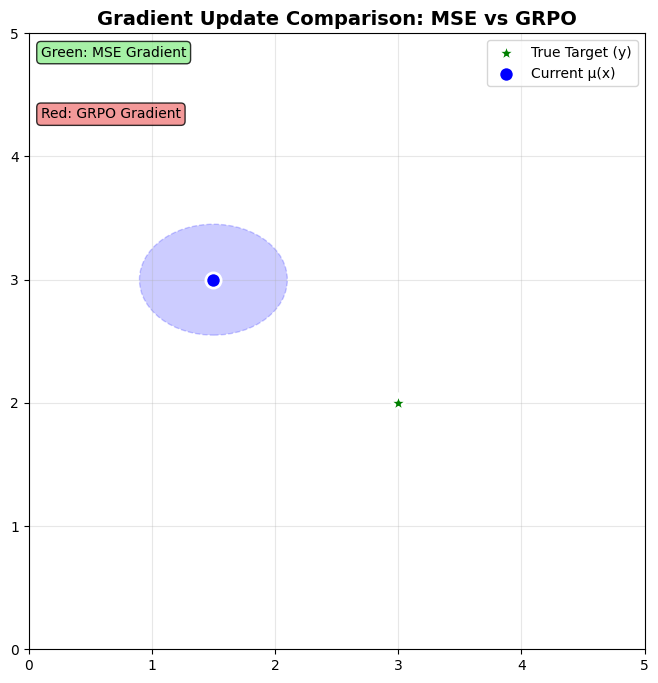

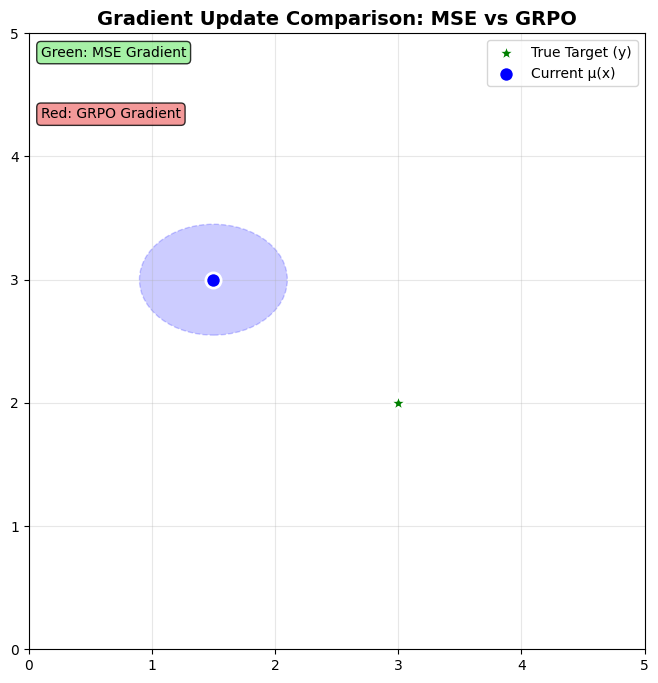

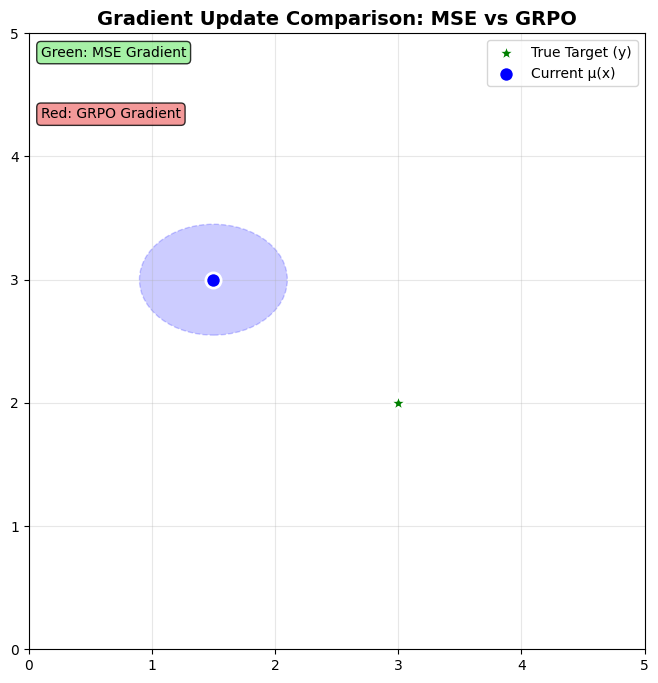

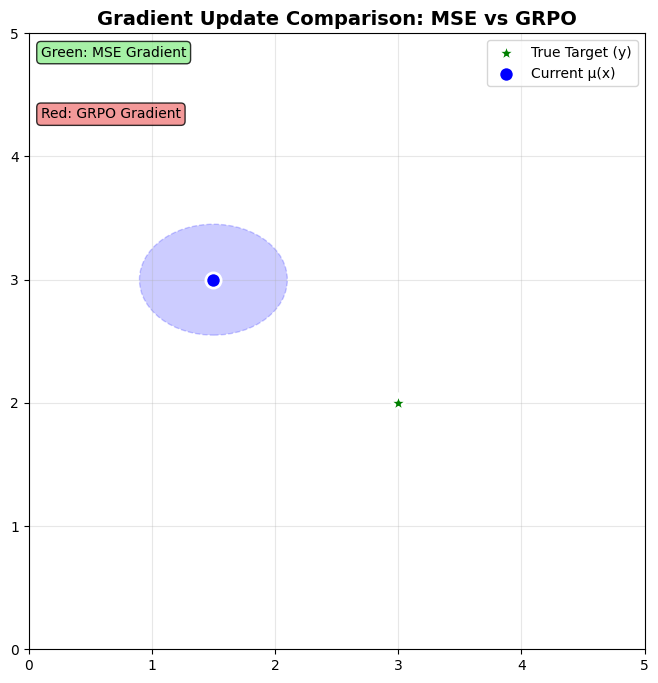

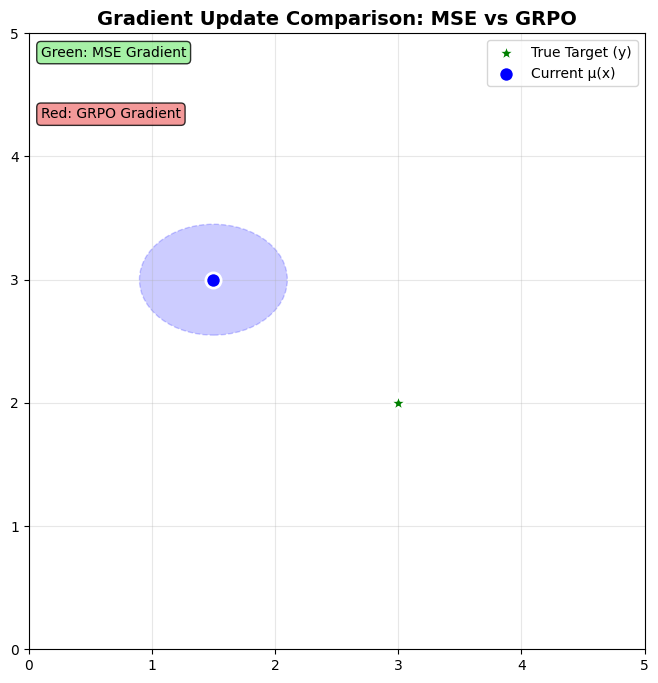

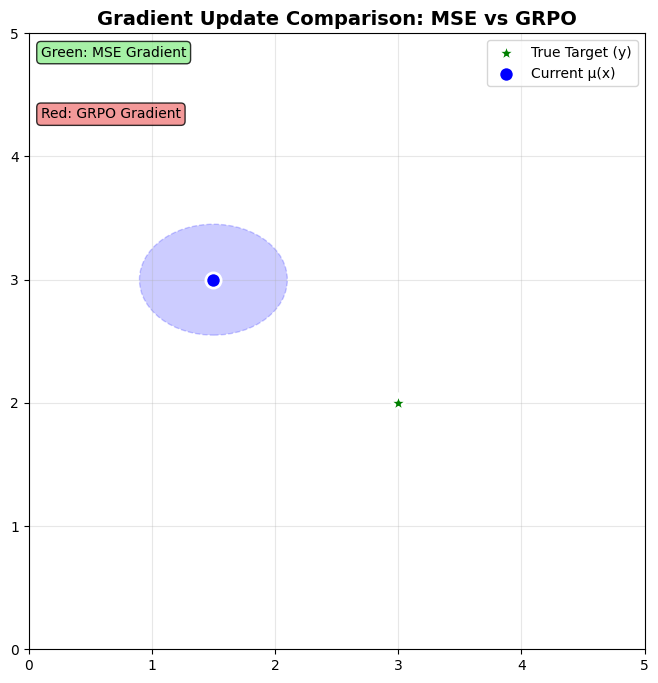

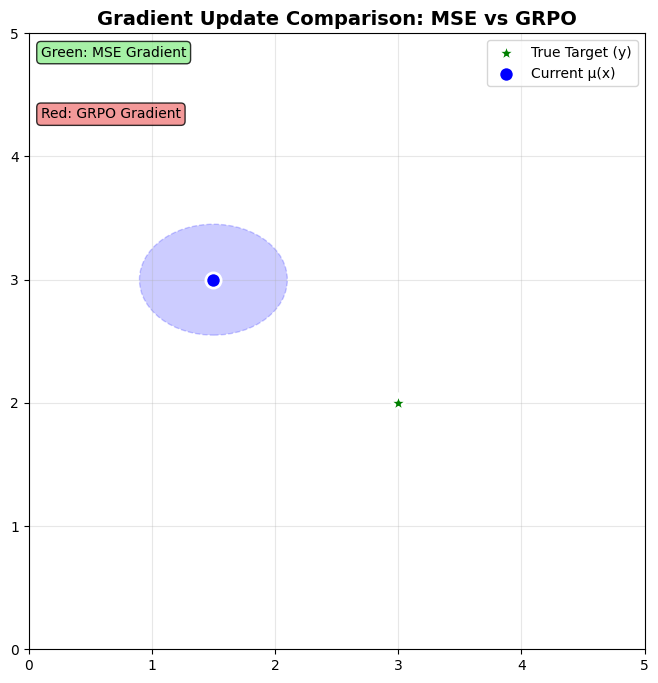

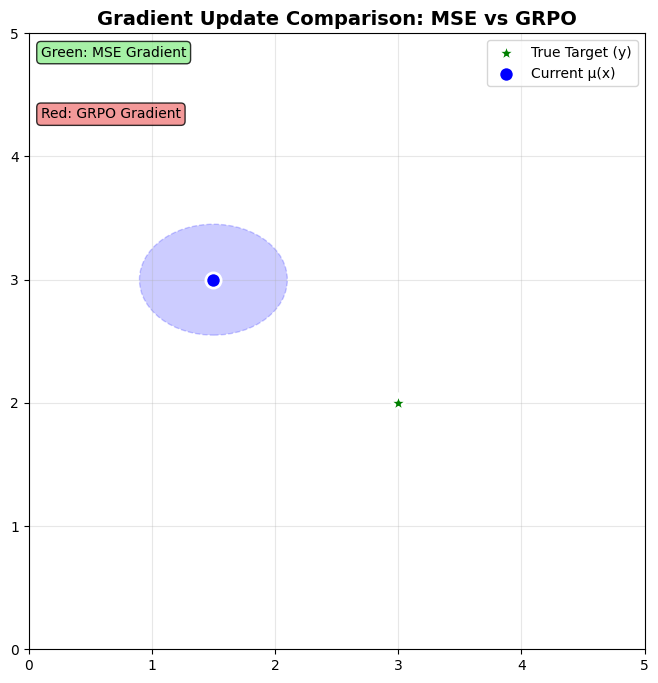

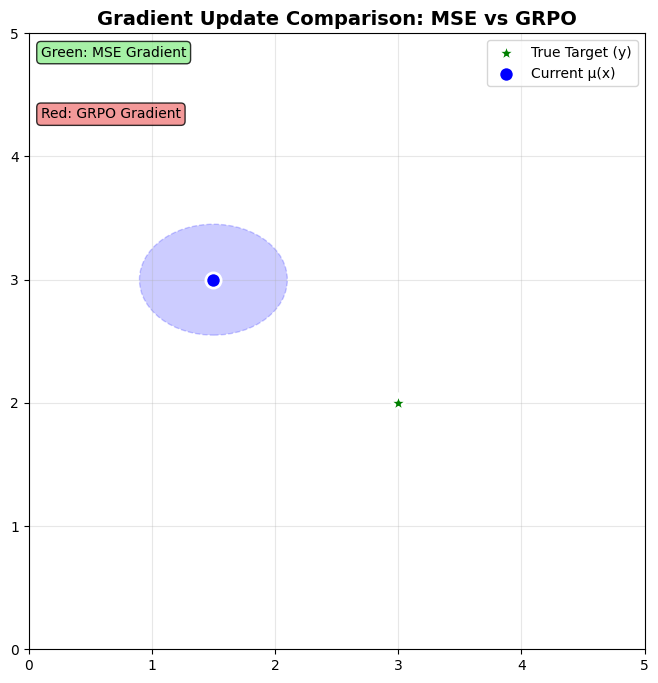

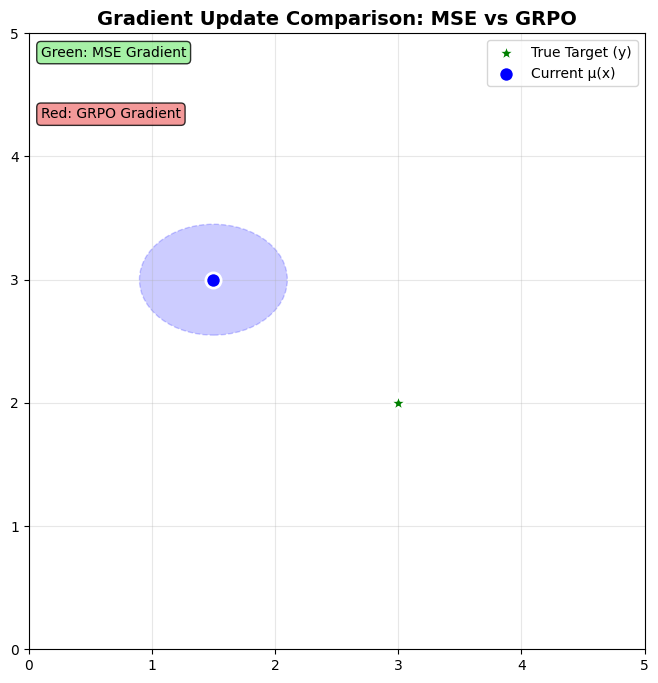

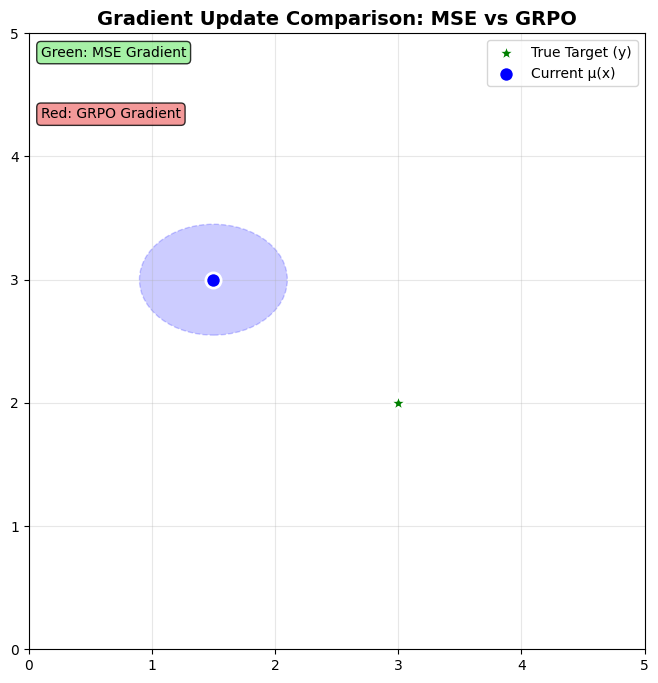

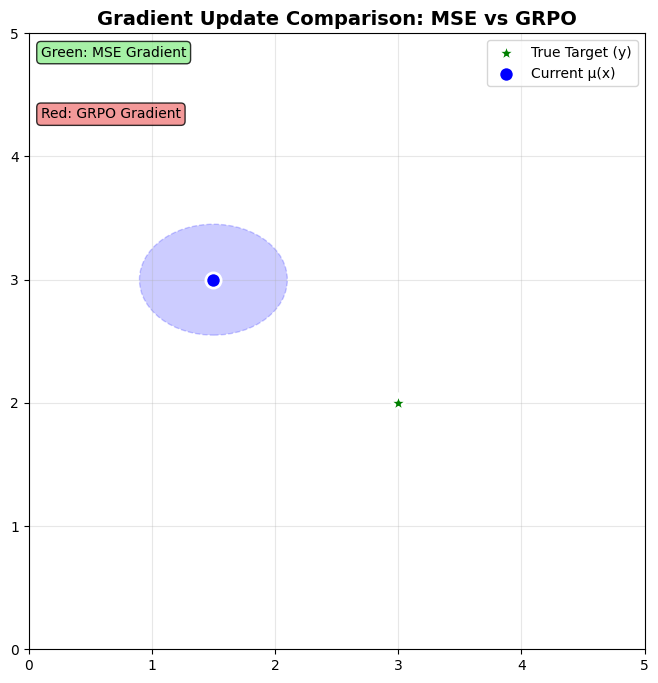

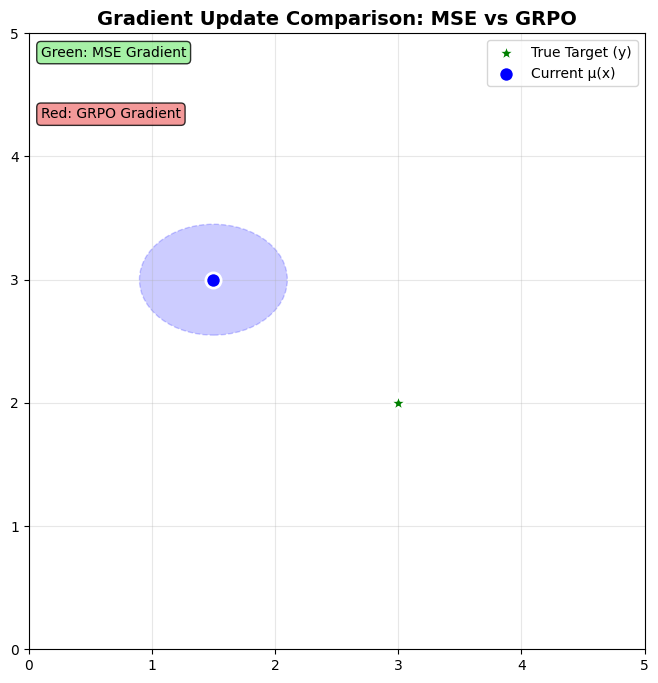

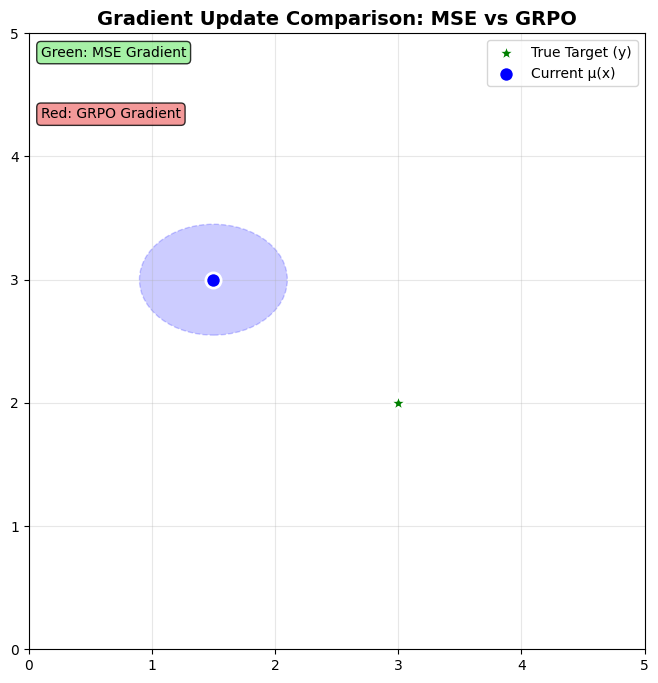

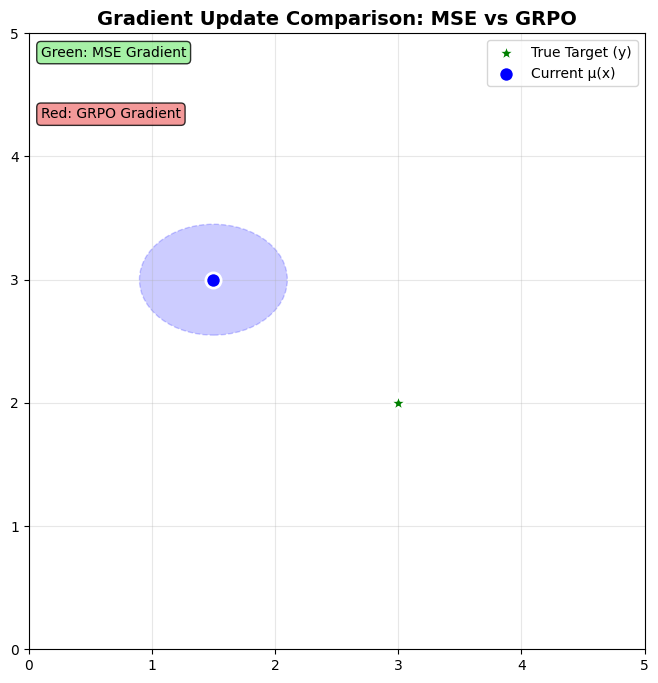

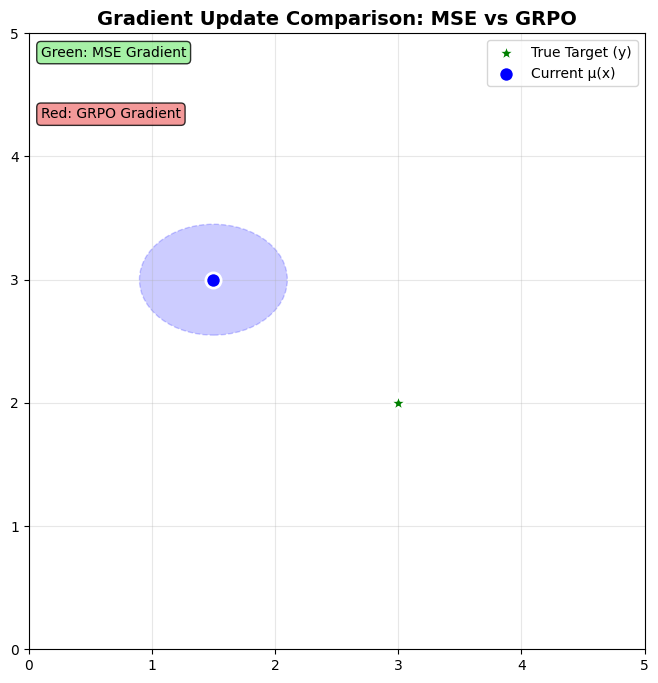

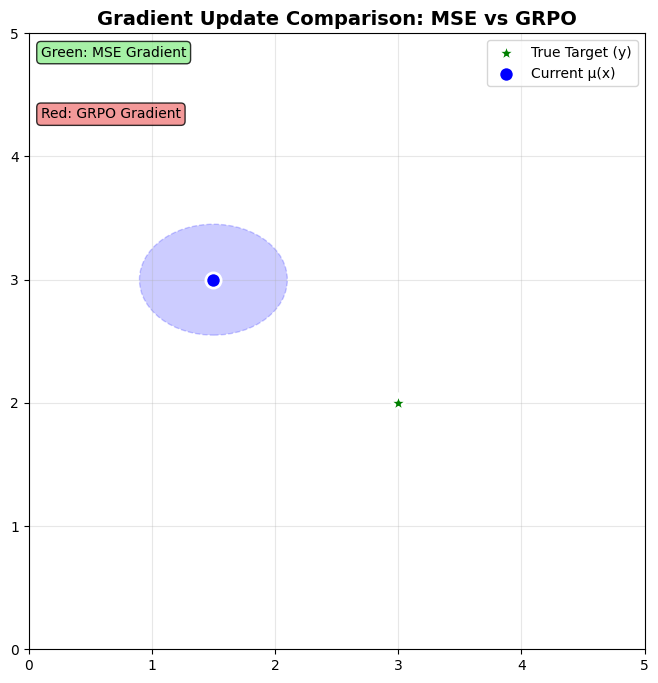

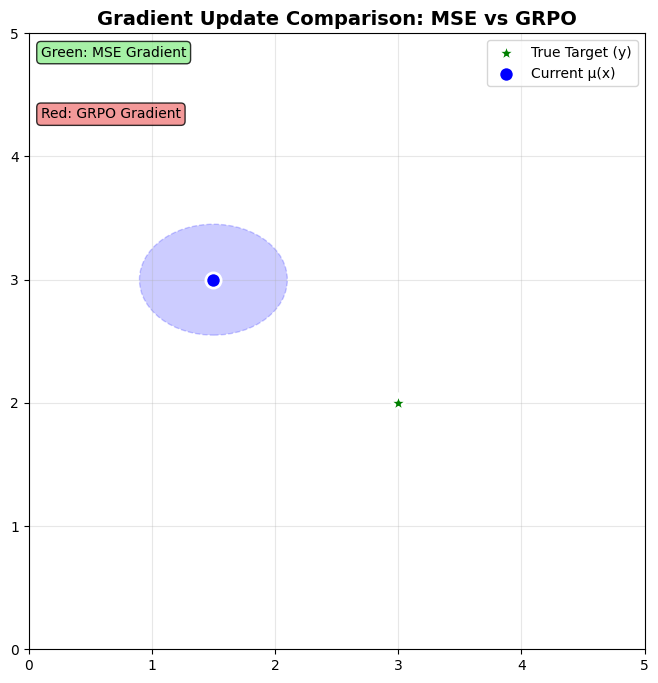

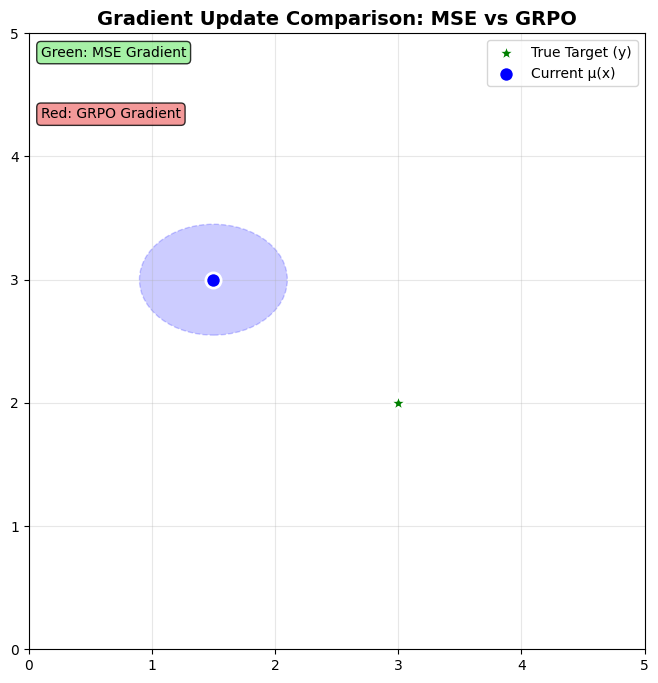

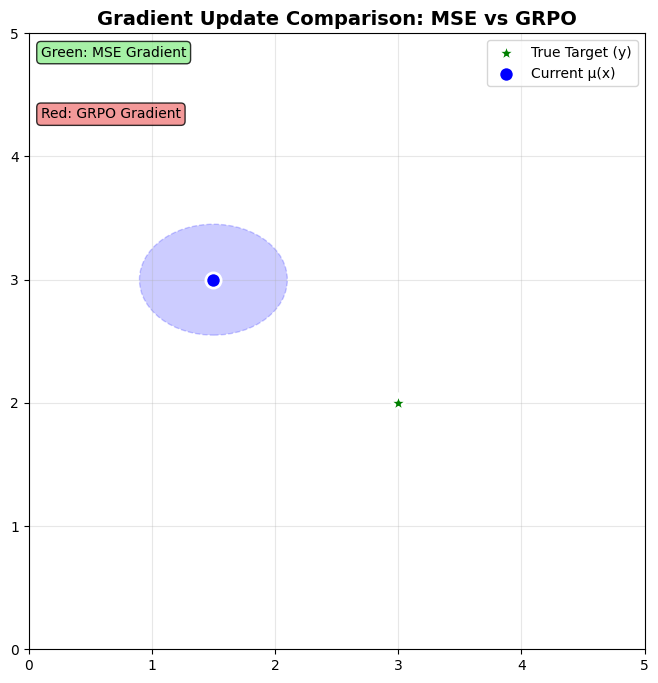

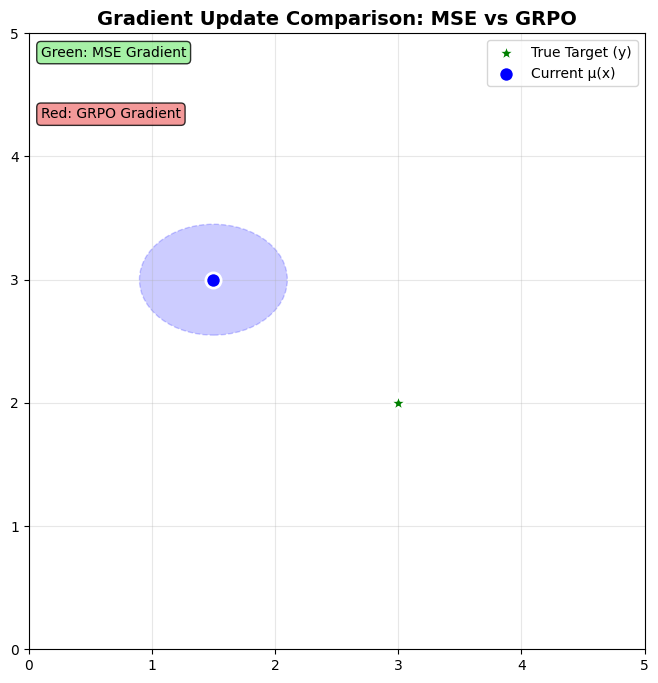

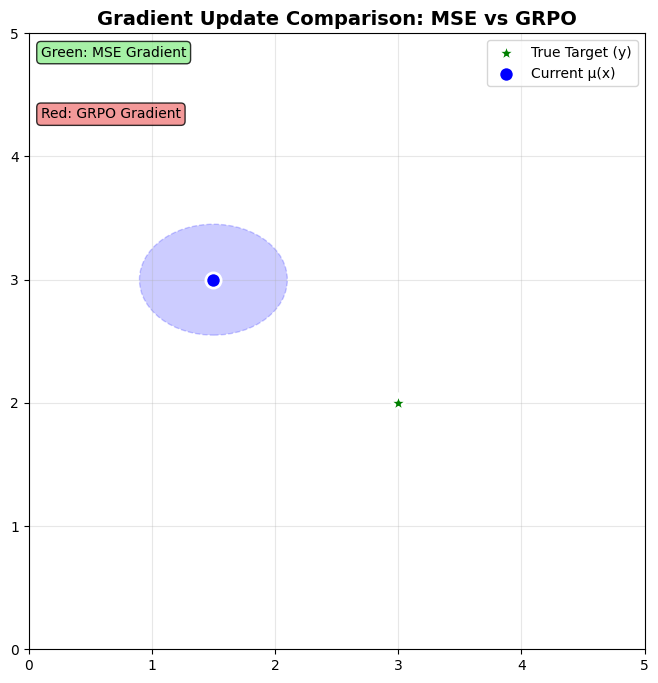

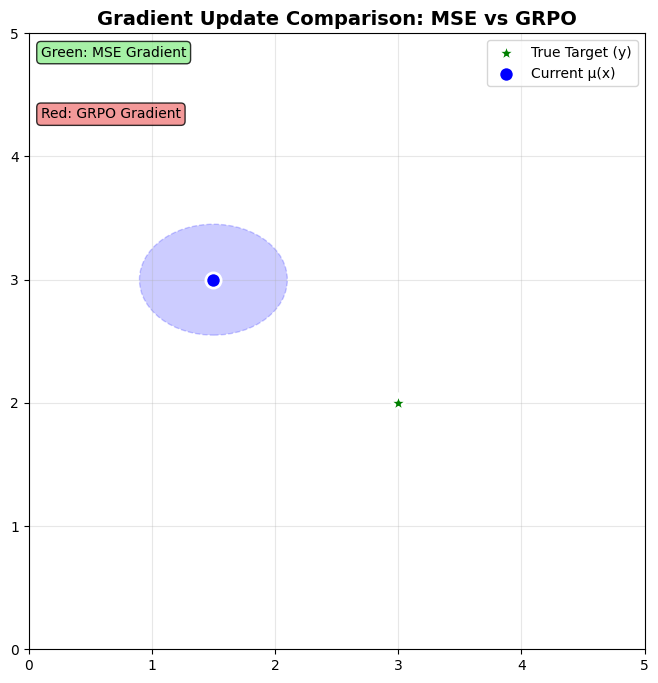

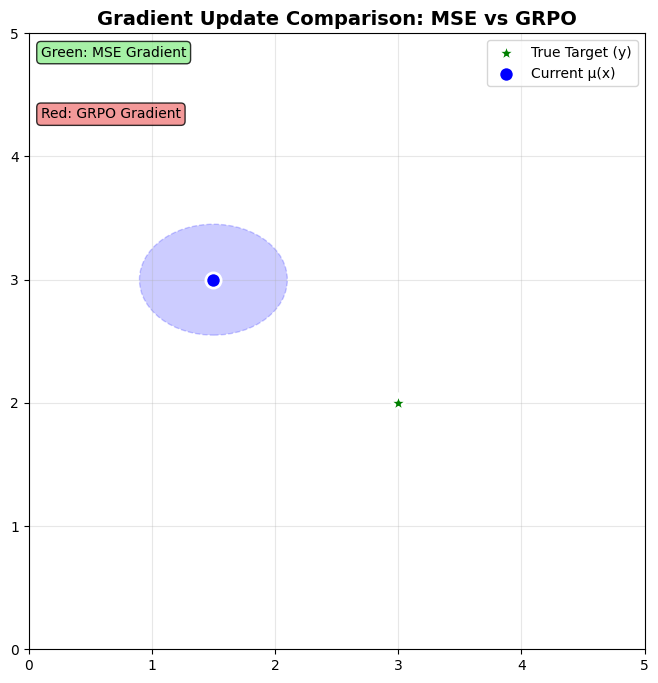

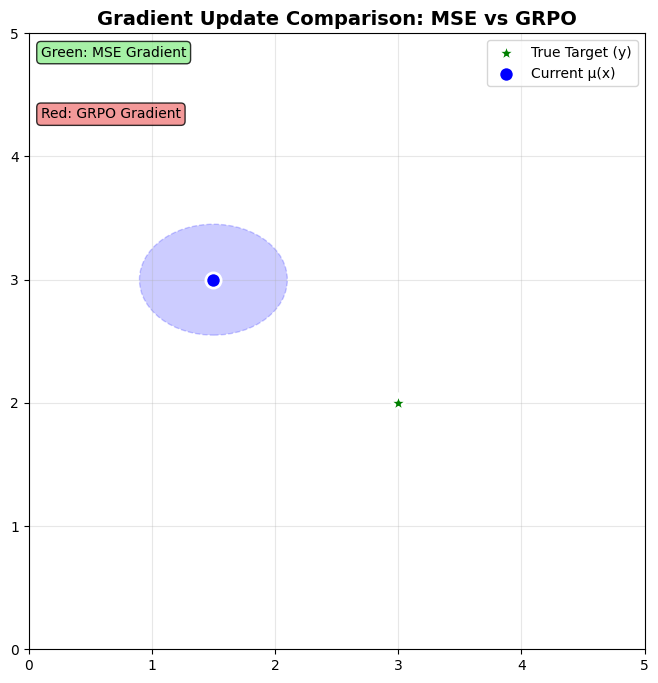

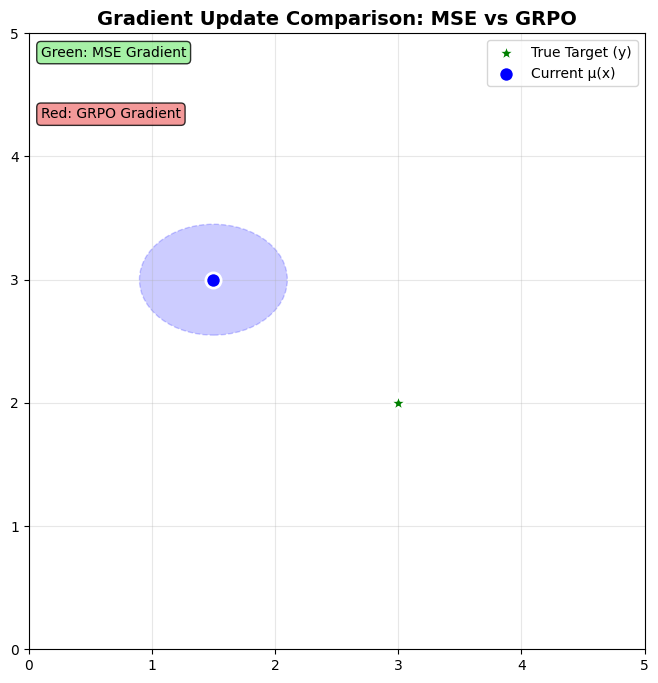

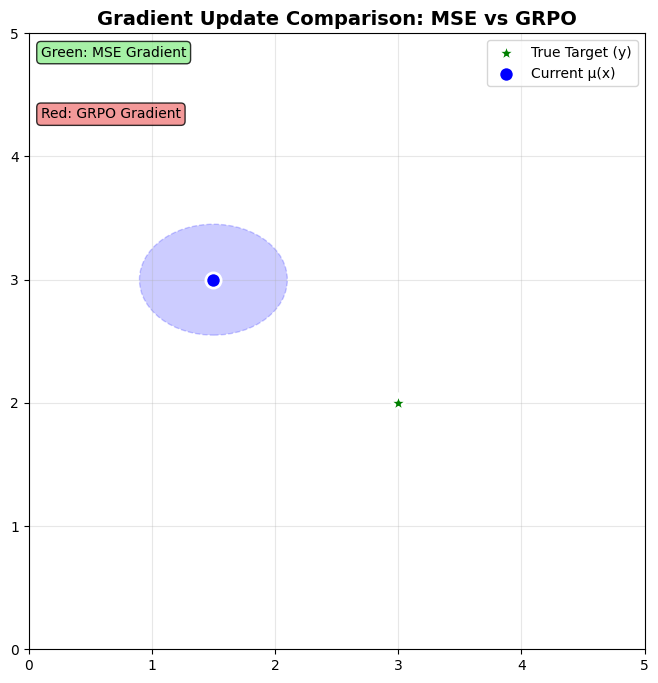

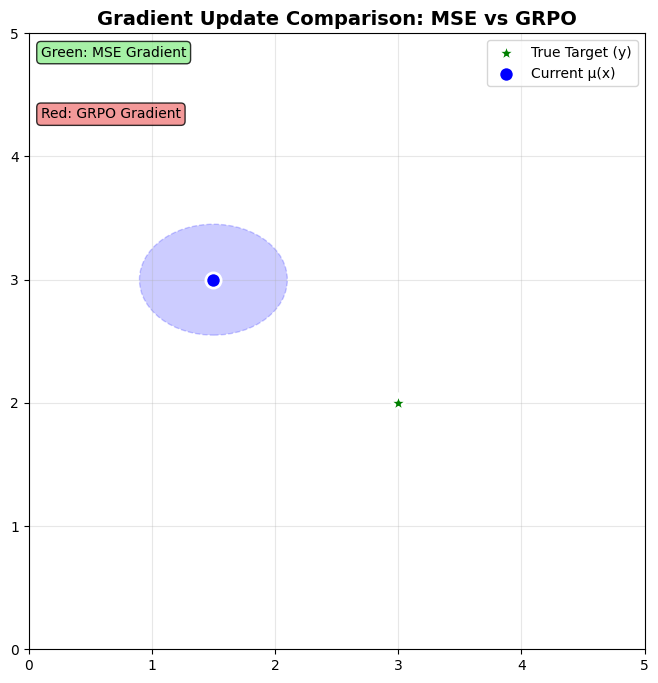

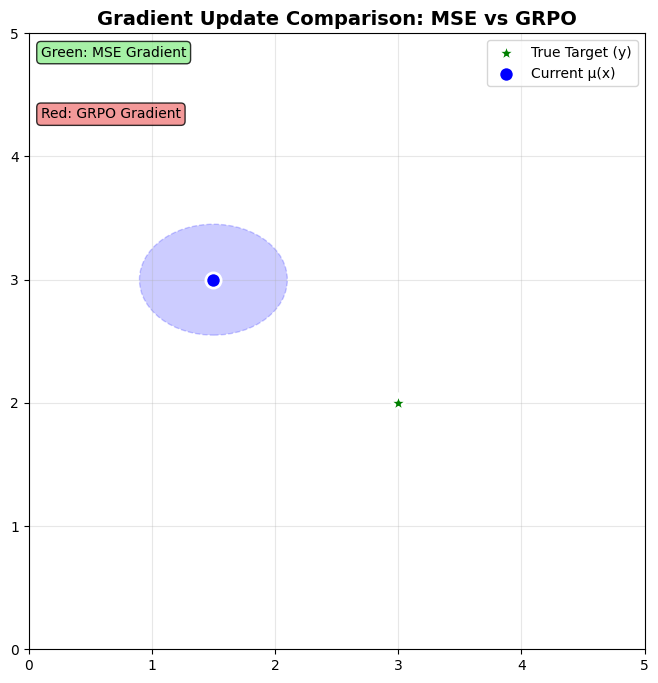

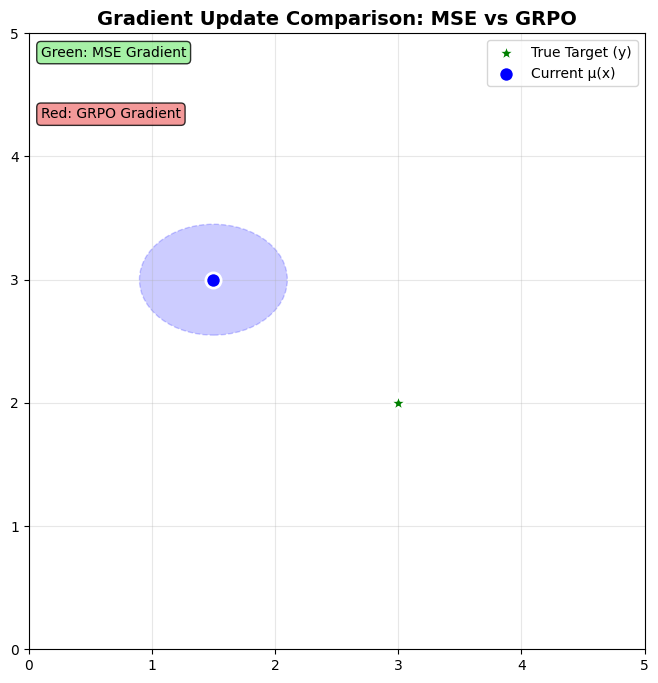

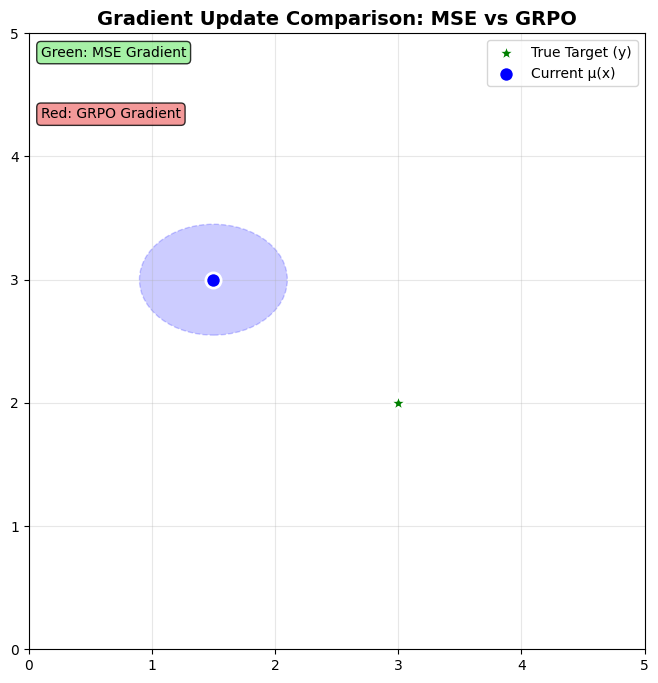

In [9]:
results_df = run_parameter_experiment()

In [10]:
results_df

,n_samples,sigma,reward_scale,avg_angle_diff,std_angle_diff,avg_magnitude_ratio
0,5,0.2,1.0,43.452224,36.692756,0.116253
1,5,0.2,2.0,35.718566,32.421071,0.144409
2,5,0.2,3.0,32.713391,30.750944,0.160144
3,5,0.2,4.0,32.277130,28.958711,0.167888
4,5,0.4,1.0,35.653562,32.182549,0.275704
...,...,...,...,...,...,...
59,20,0.6,4.0,12.178846,9.815511,0.601146
60,20,0.8,1.0,10.221030,9.362554,0.577075
61,20,0.8,2.0,10.005777,9.305842,0.703056
62,20,0.8,3.0,10.721331,9.131726,0.742897
